# <font color='purple'>Cell pose QC statistics: cell count in tiles </font> 
## Nancy, May 17 2023


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
sns.color_palette("husl", 8)
plt.rcParams["image.cmap"] = "Set1"


In [2]:
##MOMAPS_HOME = os.getenv("MOMAPS_HOME") 
MOMAPS_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps' # because I'm running from Sagy's user
LOGS_PATH = os.path.join(MOMAPS_HOME, 'src', 'preprocessing', 'logs')
#LOGS_PATH = '/Users/nancy/PycharmProjects/MOmaps/logs'

In [20]:
files_pds = []

# Go over all files under logs
for file in os.listdir(LOGS_PATH):
    # Take only "cell_count_stats" CSV files
    if file.endswith(".csv") and file.startswith("cell_count_stats"):

        # Load each CSV
        df = pd.read_csv(os.path.join(LOGS_PATH,file), 
                         index_col=None, 
                         header=0, 
                         # NY: converters make the code slow...
                         #converters={'cells_counts': pd.eval, 'whole_cells_counts': pd.eval}
                        )
        
        ##print(file, df.shape) 
        
        # Combine them to a single dataframe
        if (not df.empty):
            files_pds.append(df)
            
print("\nTotal of", len(files_pds), "files were read.")



Total of 39 files were read.


In [21]:
all_df = pd.concat(files_pds, axis=0).reset_index()
print(all_df.shape)
#all_df.sample(50)

(163887, 20)


## Handle duplicates
### 9 lines * 11 panels * 200 DAPI images = ~19,800 DAPI images in batch

In [22]:
all_df['site_num'] = all_df.filename.str.split("_").str[-1]
#all_df.head()

In [23]:
# drop rows with duplicated "filename-batch-cellline-panel-site"  combination, but keep the row with max "cells_count_mean"
df_tmp = all_df.sort_values('cells_count_mean', ascending=False).drop_duplicates(subset=['filename','batch', 'cell_line', 'panel', 'condition', 'rep', 'marker'], 
                            keep='first',
                            inplace=False).sort_index()

print("After duplication removal #1:", df_tmp.shape)

# Now handle correpted duplicated rows (same batch-cellline-panel-site, but different file name)
_subset=['site_num', 'batch', 'cell_line', 'panel', 'condition', 'rep', 'marker', 
        'cells_counts', 'cells_count_mean', 'cells_count_std',
        'whole_cells_counts', 'whole_cells_count_mean', 'whole_cells_count_std',
        'n_valid_tiles', 'cells_count_in_valid_tiles_mean',
        'cells_count_in_valid_tiles_std',
        'whole_cells_count_in_valid_tiles_mean',
        'whole_cells_count_in_valid_tiles_std']


df = df_tmp.drop_duplicates(subset=_subset,inplace=False)

print("After duplication removal #2:", df.shape)
#df.head()

After duplication removal #1: (136596, 21)
After duplication removal #2: (134517, 21)


In [25]:
#df = df.copy()
df.loc[df.cell_line=='FUSHetero', 'cell_line'] = 'FUSHeterozygous'
df.loc[df.cell_line=='FUSHomo', 'cell_line'] = 'FUSHomozygous'
df.loc[df.condition=='stressed', 'condition'] = 'stress'

df['cell_line_cond'] = df['cell_line']
df.loc[df.cell_line=='WT', 'cell_line_cond'] = df.cell_line + " " + df.condition
np.unique(df['cell_line_cond'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array(['FUSHeterozygous', 'FUSHomozygous', 'FUSRevertant', 'OPTN', 'SCNA',
       'TBK1', 'TDP43', 'WT Chloroquine', 'WT DMSO100uM', 'WT DMSO1uM',
       'WT Edavarone', 'WT Pridopine', 'WT Riluzole', 'WT Tubastatin',
       'WT Untreated', 'WT stress'], dtype=object)


# <font color='red'>Number of sites in each batch and cellline </font>


<AxesSubplot:xlabel='batch', ylabel='count'>

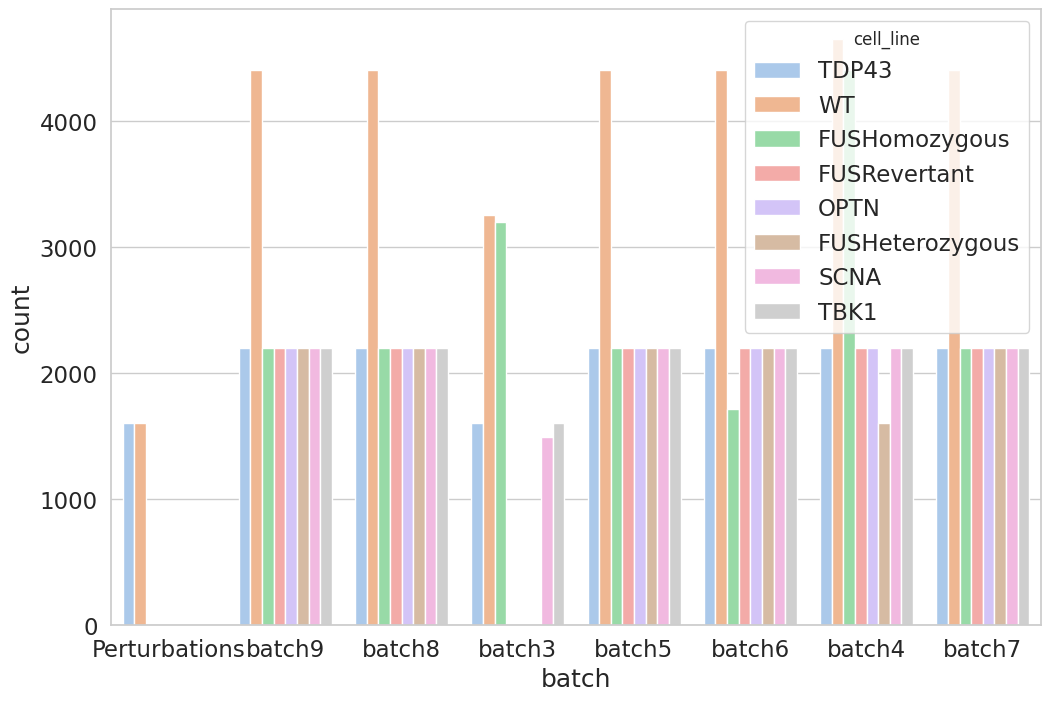

In [26]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='batch', hue='cell_line', palette=sns.color_palette('pastel'))


In [8]:
columns = ['batch', 'cell_line', 'panel', 'condition', 'rep', 'marker']

for col in columns:
    print("\nColumn", col, "has", df[col].nunique(), "unique values.\n" , df[col].value_counts().sort_values())


Column batch has 8 unique values.
 Perturbations     3200
batch3           11149
batch4           17909
batch6           19313
batch9           19800
batch8           19800
batch5           19800
batch7           19800
Name: batch, dtype: int64

Column cell_line has 10 unique values.
 FUSHetero           3803
FUSHomo             6000
FUSHeterozygous     8800
FUSHomozygous      10819
OPTN               11000
FUSRevertant       13200
SCNA               14695
TBK1               14800
TDP43              16400
WT                 31254
Name: cell_line, dtype: int64

Column panel has 13 unique values.
 Panel_B     1600
Panel_A     1600
panelC     10424
panelA     10624
panelB     10626
panelD     11826
panelG     11887
panelH     11973
panelK     12020
panelE     12020
panelF     12029
panelJ     12066
panelI     12076
Name: panel, dtype: int64

Column condition has 10 unique values.
 Riluzole          400
Pridopine         400
DMSO100uM         400
Tubastatin        400
Chloroquine       40

In [9]:
pd.set_option('display.max_rows', 300)
combo_counts = df.groupby(['batch', 'cell_line', 'panel', 'condition', 'marker']).size().unstack(level=4)
combo_counts.columns = ['Number of processed sites']
combo_counts.head(300).sort_values(by='Number of processed sites').head(300)

Number of processed sites
batch         cell_line       panel   condition                             
batch4        FUSHetero       panelG  Untreated                            1
                              panelD  Untreated                            1
                              panelC  Untreated                            1
batch3        WT              panelH  stress                               2
                              panelF  stress                               5
                              panelJ  stress                              43
batch4        FUSHomozygous   panelK  Untreated                           64
                              panelJ  Untreated                           66
                              panelE  Untreated                           66
                              panelF  Untreated                           66
                              panelC  Untreated                           67
                              panelD  Untreated                           67
                              panelB  Untreated                           69
                              panelA  Untreated                           70
batch3        SCNA            panelH  Untreated                           95
Perturbations WT              Panel_B Untreated                          100
                                      Tubastatin                         100
                                      Riluzole                           100
                                      Pridopine                          100
                                      Edavarone                          100
                                      DMSO1uM                            100
                                      DMSO100uM                          100
                                      Chloroquine                        100
              TDP43           Panel_A Chloroquine                        100
              WT              Panel_A Tubastatin                         100
                                      Untreated                          100
              TDP43           Panel_B Tubastatin                         100
                                      Riluzole                           100
                                      Pridopine                          100
                                      Edavarone                          100
                                      DMSO1uM                            100
                                      Chloroquine                        100
                              Panel_A Untreated                          100
                                      Tubastatin                         100
                                      Riluzole                           100
                                      Pridopine                          100
                                      Edavarone                          100
                                      DMSO1uM                            100
                              Panel_B DMSO100uM                          100
              WT              Panel_A Pridopine                          100
              TDP43           Panel_A DMSO100uM                          100
              WT              Panel_A Riluzole                           100
                                      Edavarone                          100
                                      DMSO1uM                            100
              TDP43           Panel_B Untreated                          100
              WT              Panel_A DMSO100uM                          100
                                      Chloroquine                        100
batch4        FUSHomozygous   panelH  Untreated                          118
                              panelI  Untreated                          121
                              panelG  Untreated                          132
batch5        FUSRevertant    panelH  Untreated

(3200, 21)


condition          Chloroquine  DMSO100uM  DMSO1uM  Edavarone  Pridopine  \
cell_line panel                                                            
TDP43     Panel_A          100        100      100        100        100   
          Panel_B          100        100      100        100        100   
WT        Panel_A          100        100      100        100        100   
          Panel_B          100        100      100        100        100   

condition          Riluzole  Tubastatin  Untreated  
cell_line panel                                     
TDP43     Panel_A       100         100        100  
          Panel_B       100         100        100  
WT        Panel_A       100         100        100  
          Panel_B       100         100        100

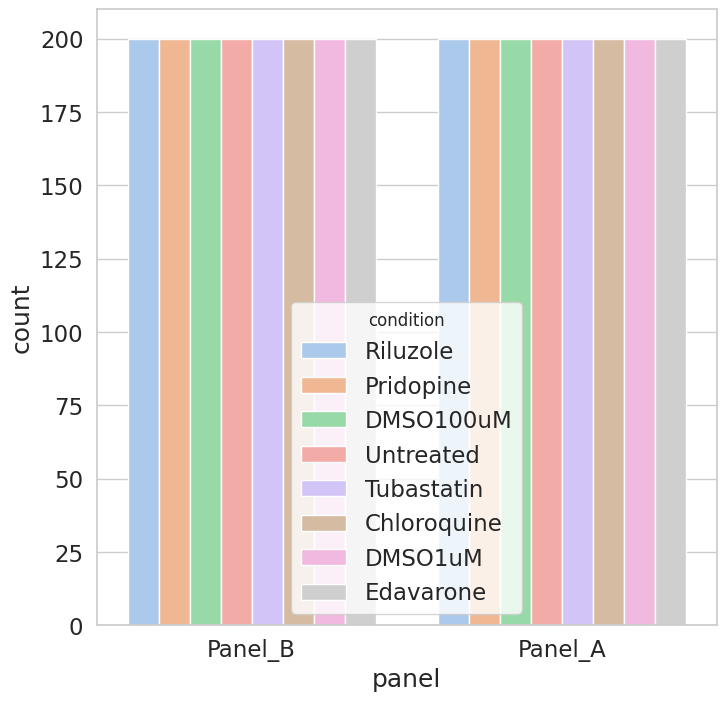

In [19]:
df_perturbations = df[df['batch']=='Perturbations']
print(df_perturbations.shape)
plt.figure(figsize=(8,8))
#sns.catplot(kind='bar', data=df_perturbations, y='batch', x=value, hue='condition', aspect=3, palette=sns.color_palette(c_palette))
sns.countplot(data=df_perturbations, x='panel', hue='condition', palette=sns.color_palette('pastel'))
df_perturbations.groupby(['cell_line', 'panel', 'condition']).size().unstack(level=2)
#sns.countplot(data=df_perturbations, x='cell_line', hue='condition', palette=sns.color_palette('pastel'))

(19800, 21)


Text(0.5, 0, 'Number valid tiles at batch 8')

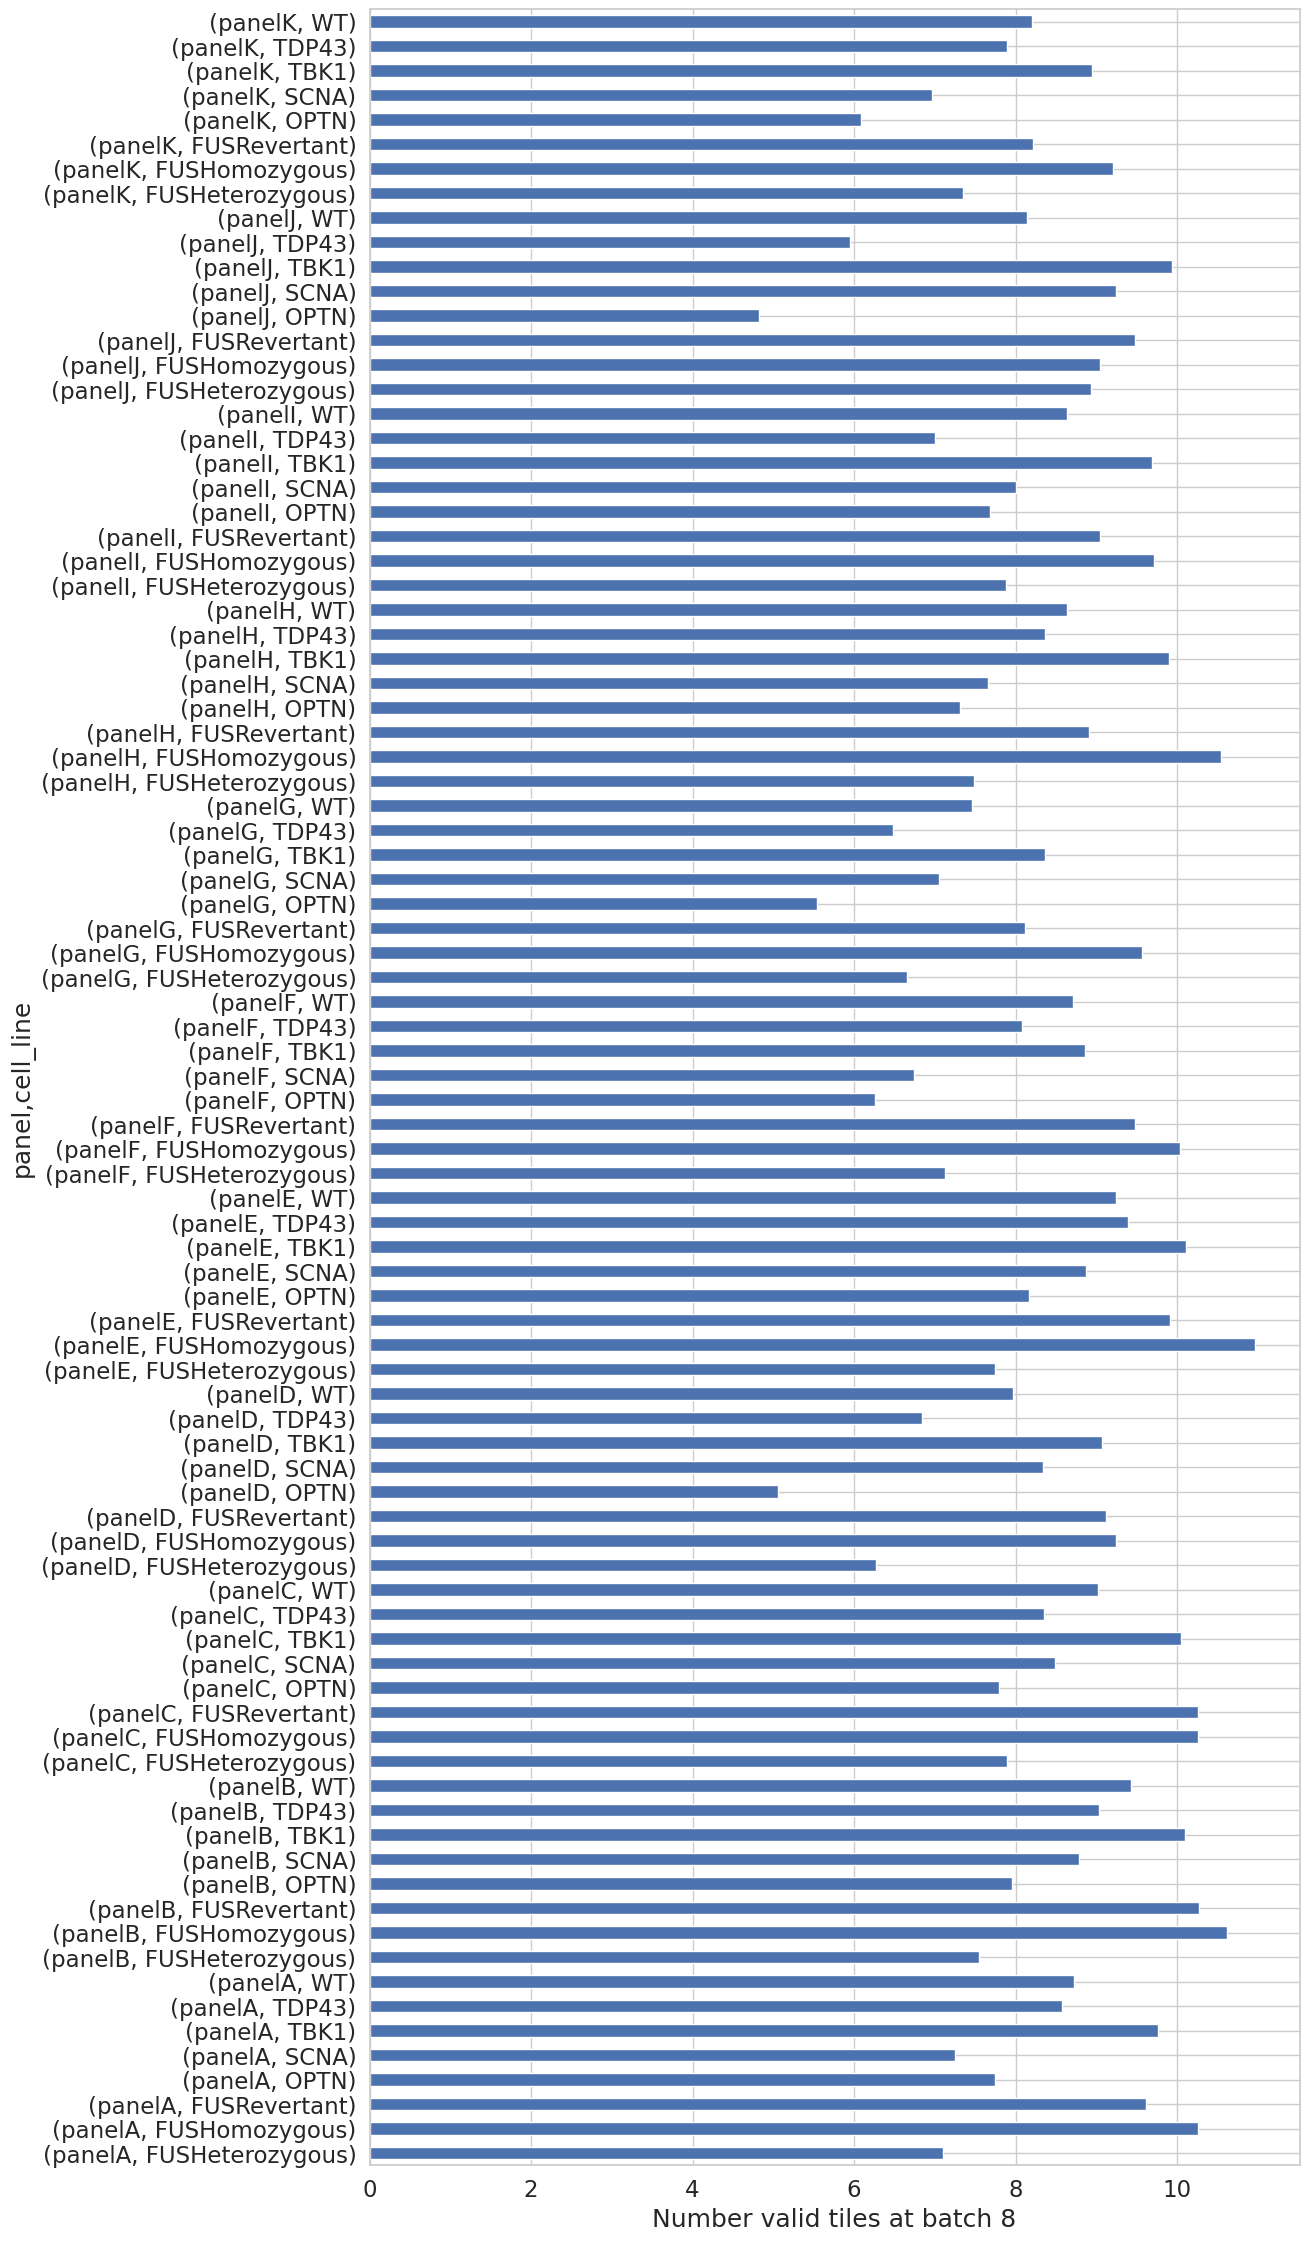

In [10]:
df_batch8 = df[df['batch']=='batch8']
print(df_batch8.shape)
##print(df_batch8[['panel', 'cell_line']].value_counts().sort_values())

plt.figure(figsize=(12,28))
g = df_batch8[['panel', 'cell_line','n_valid_tiles','condition', 'rep']].groupby(['panel', 'cell_line'])['n_valid_tiles'].mean()
g.plot.barh(stacked=True)
plt.xlabel("Number valid tiles at batch 8")


# <font color='blue'>Cell counts, whole cell counts and number of valid tiles </font>


<Figure size 800x800 with 0 Axes>

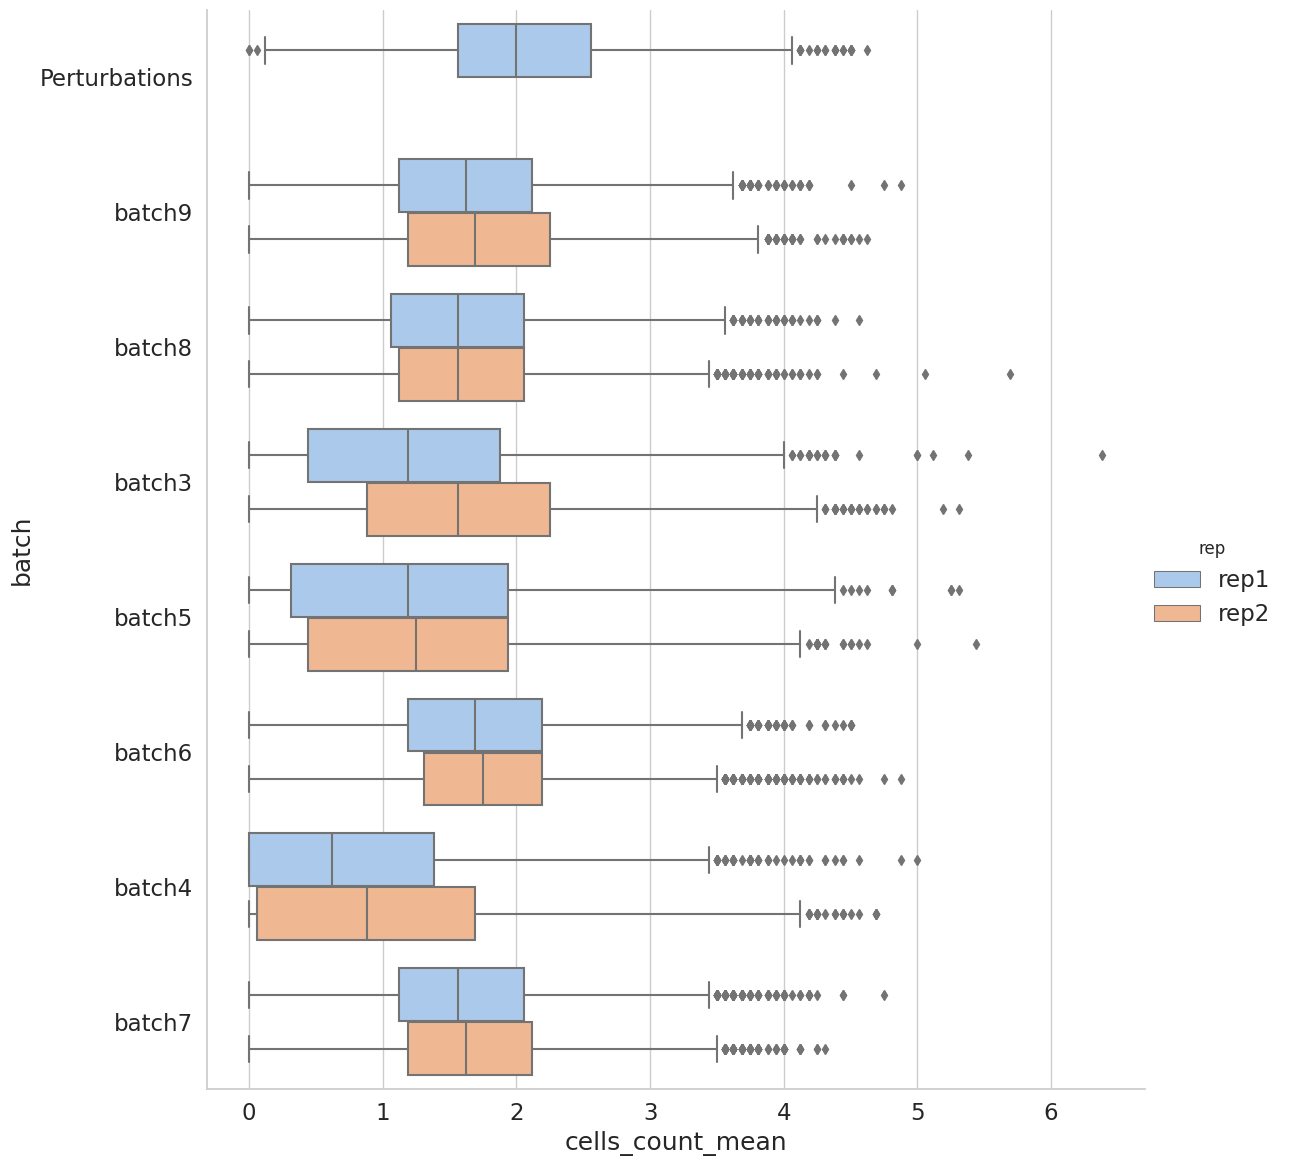

<Figure size 800x800 with 0 Axes>

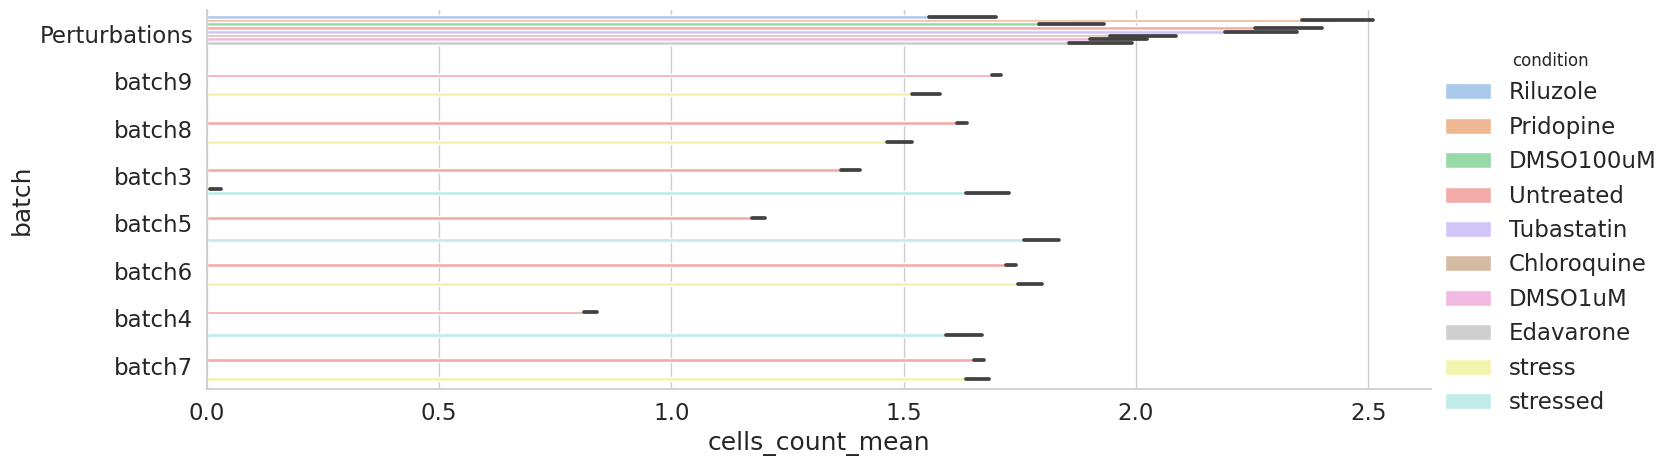

<Figure size 800x800 with 0 Axes>

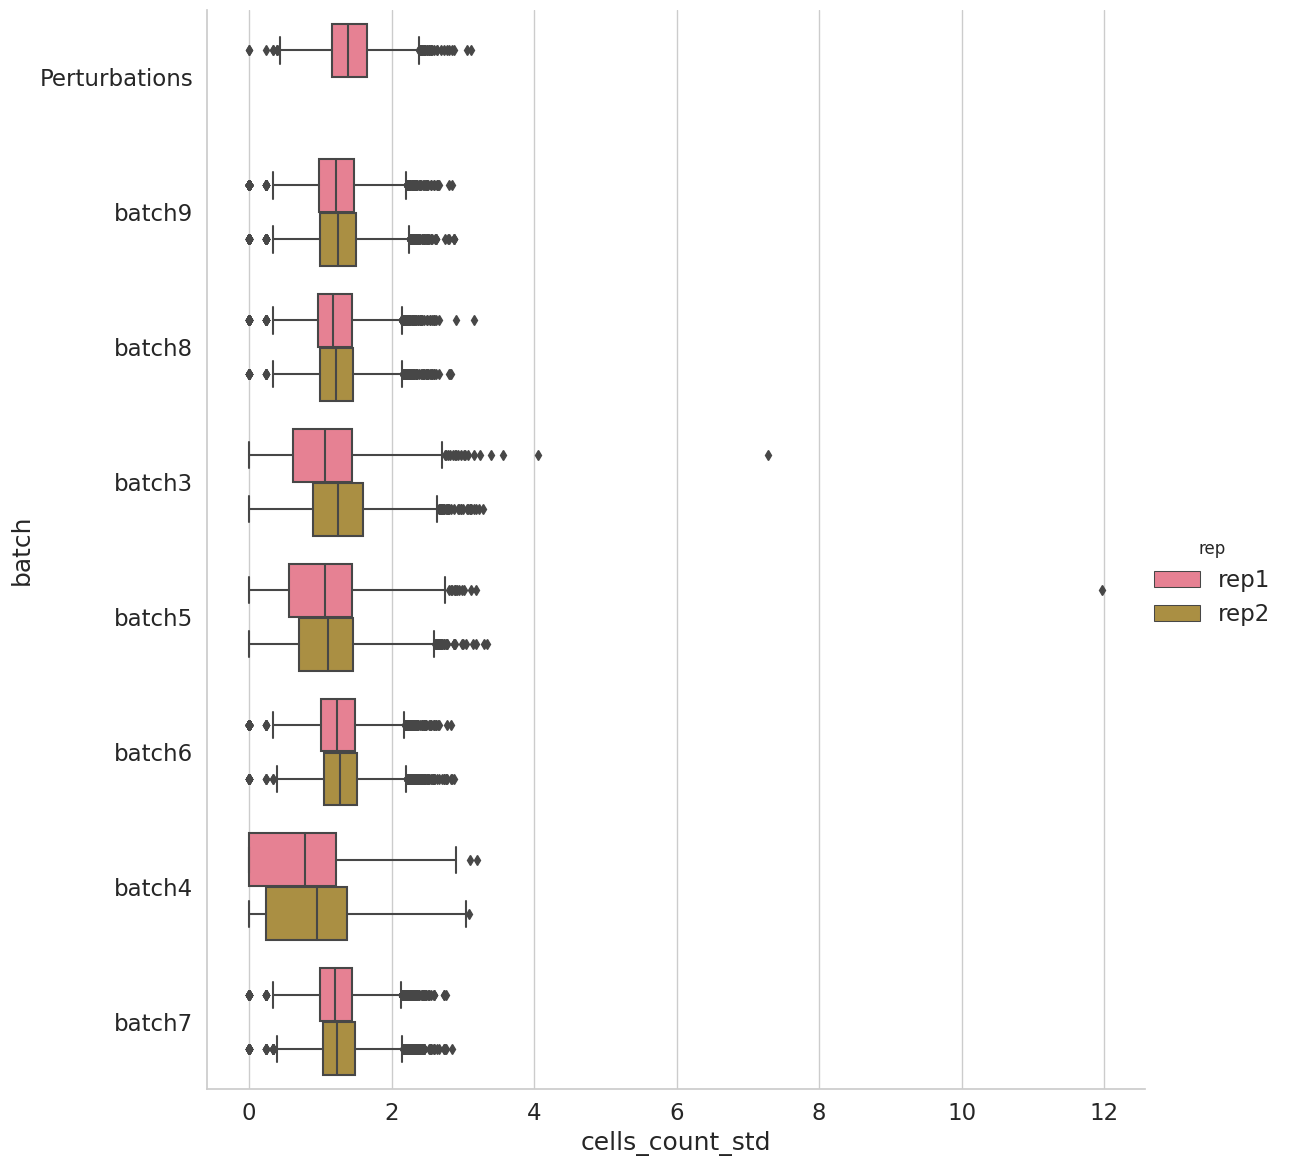

<Figure size 800x800 with 0 Axes>

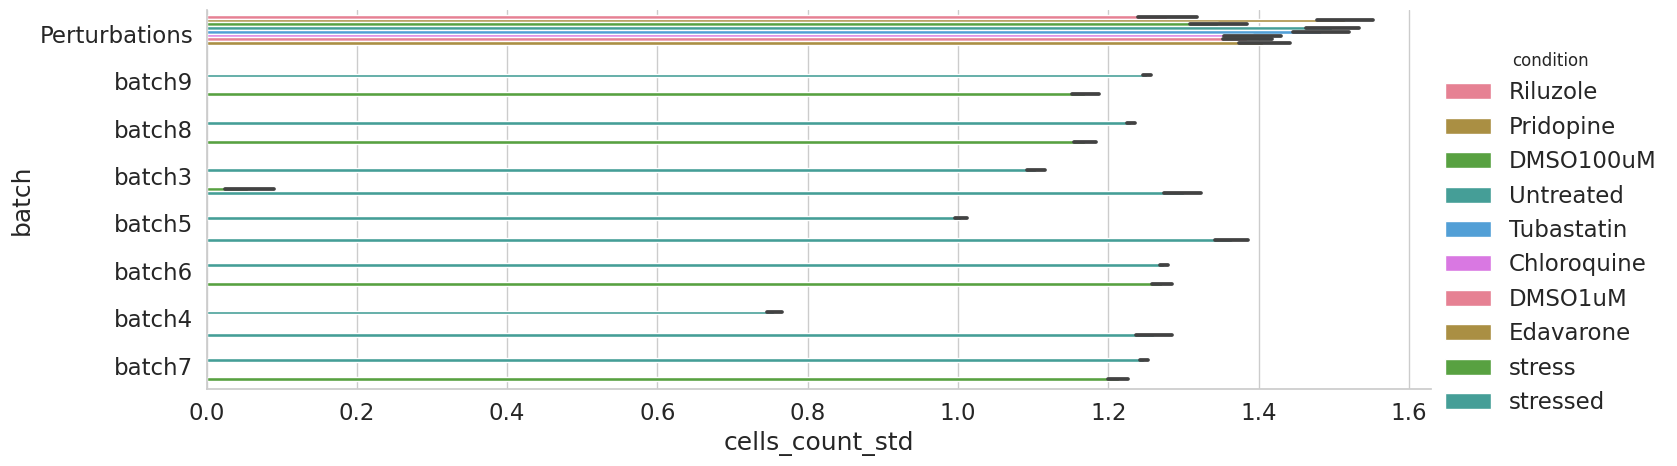

<Figure size 800x800 with 0 Axes>

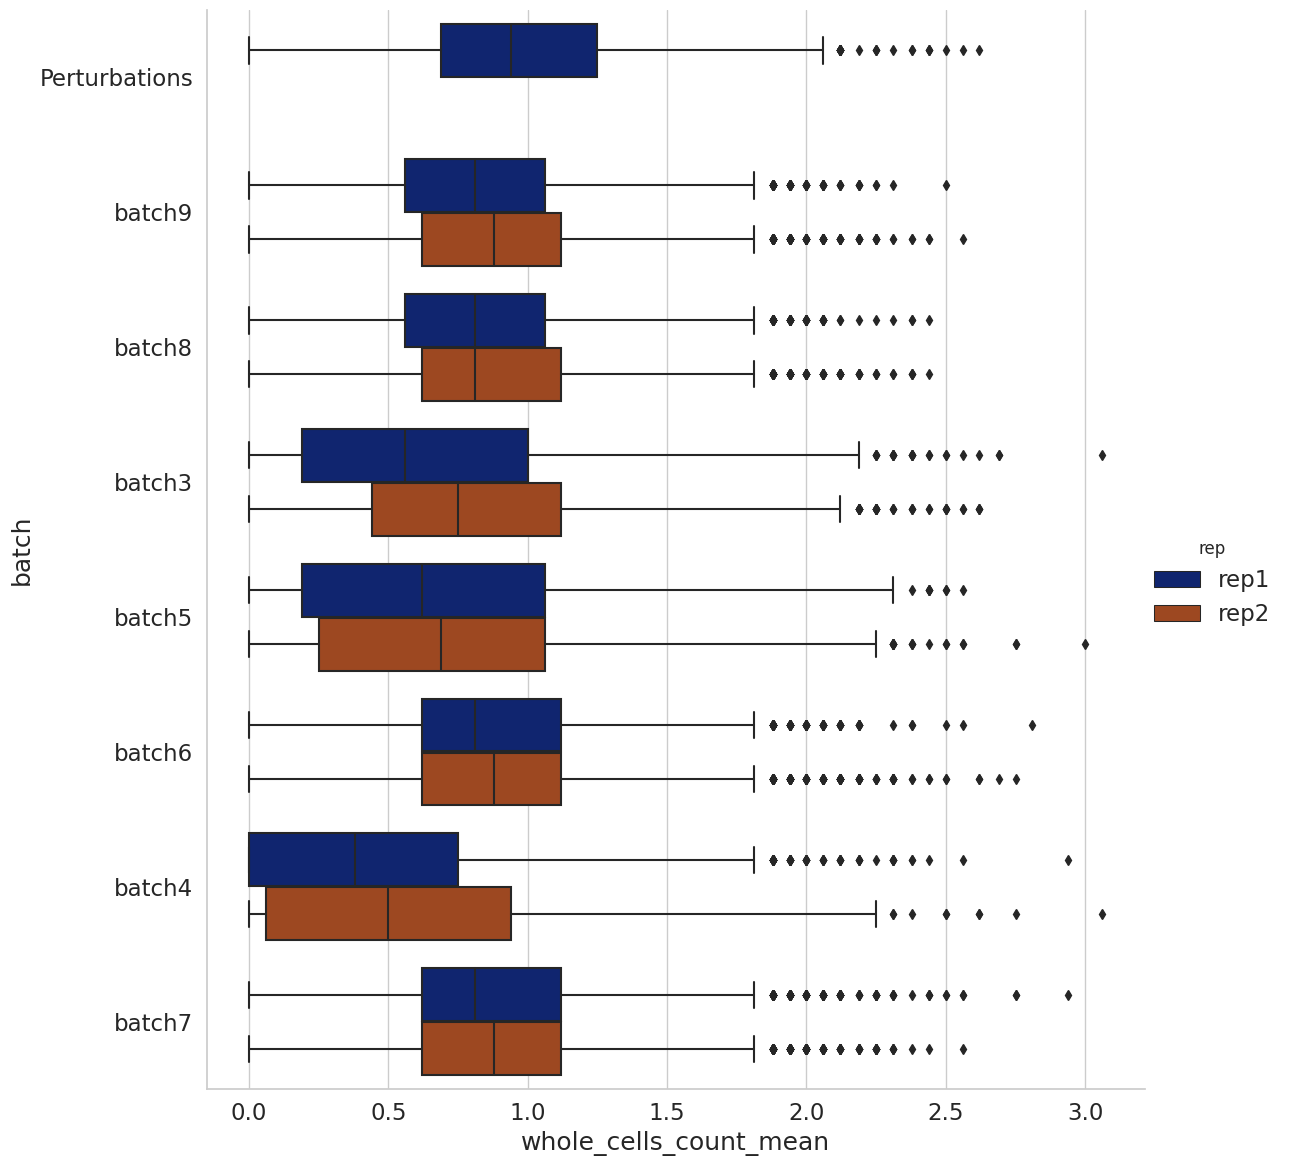

<Figure size 800x800 with 0 Axes>

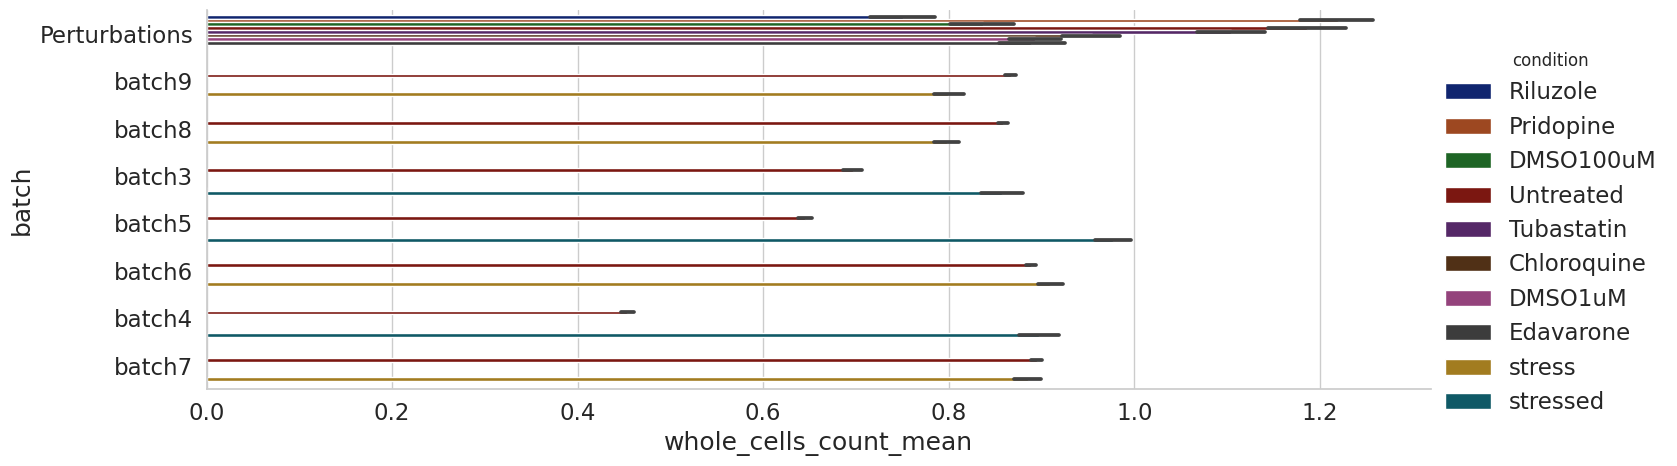

<Figure size 800x800 with 0 Axes>

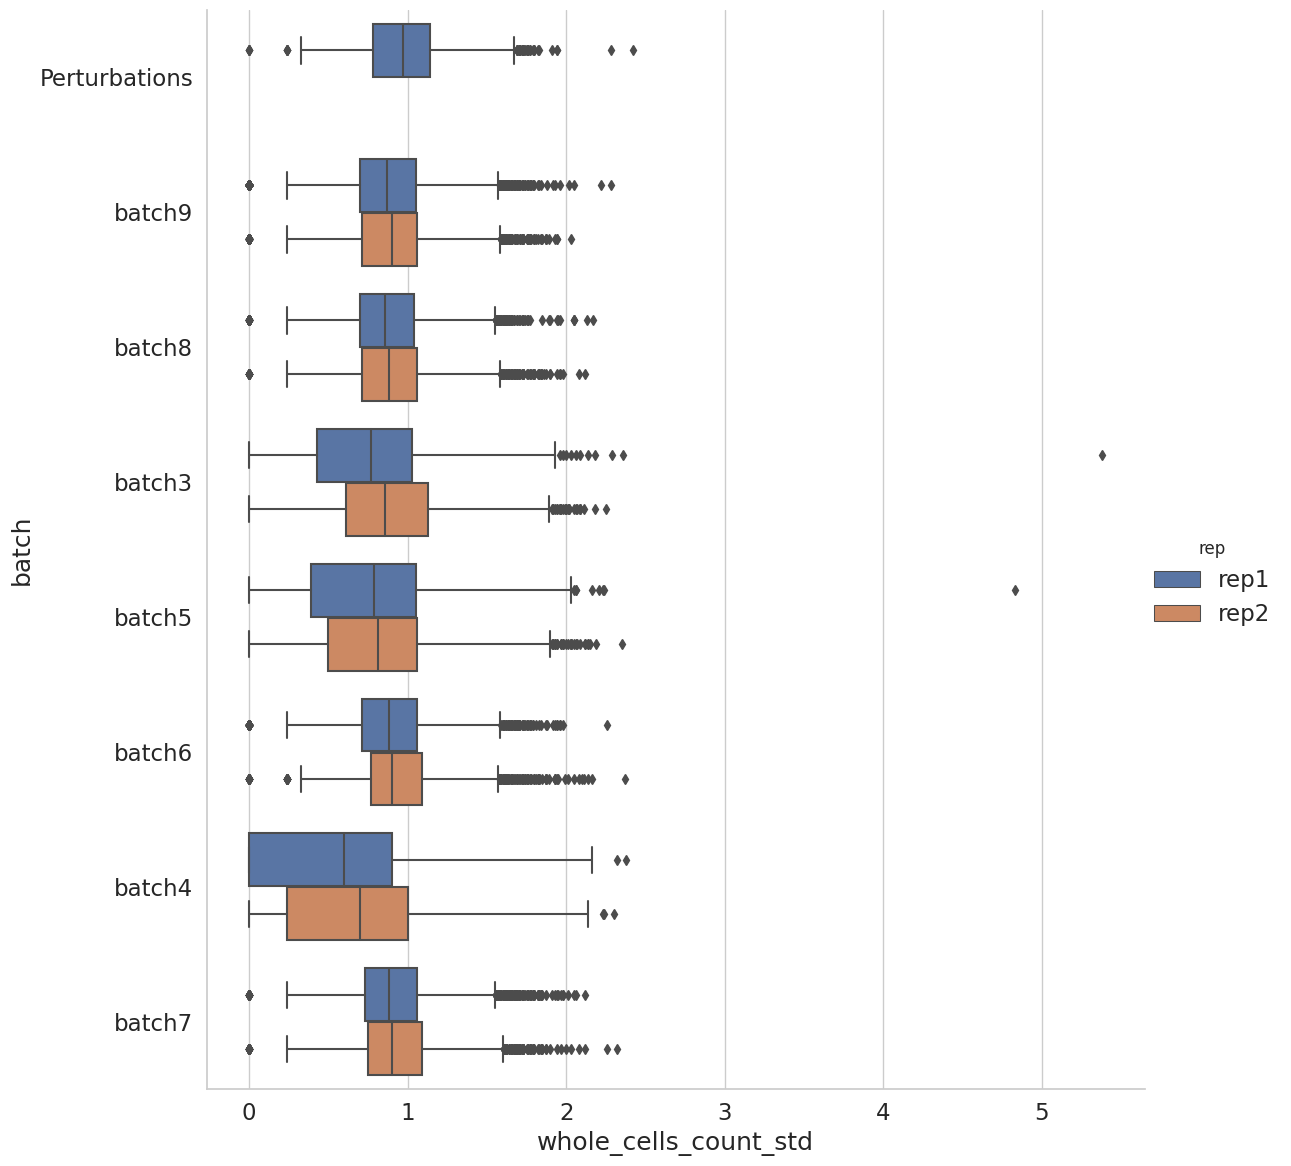

<Figure size 800x800 with 0 Axes>

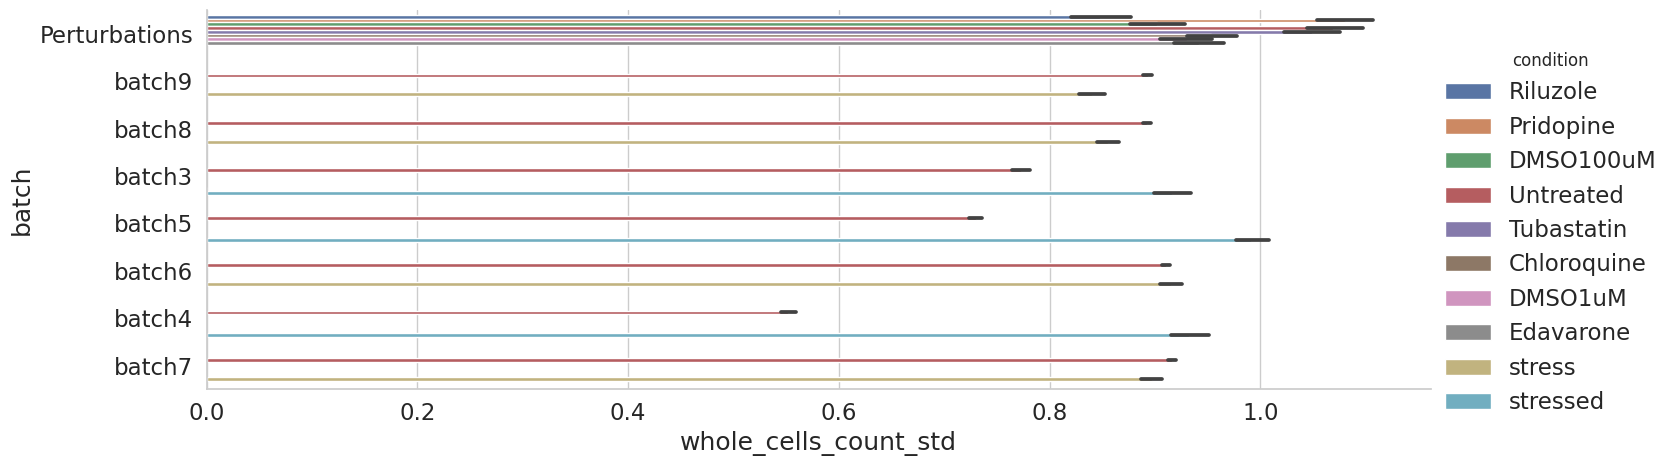

<Figure size 800x800 with 0 Axes>

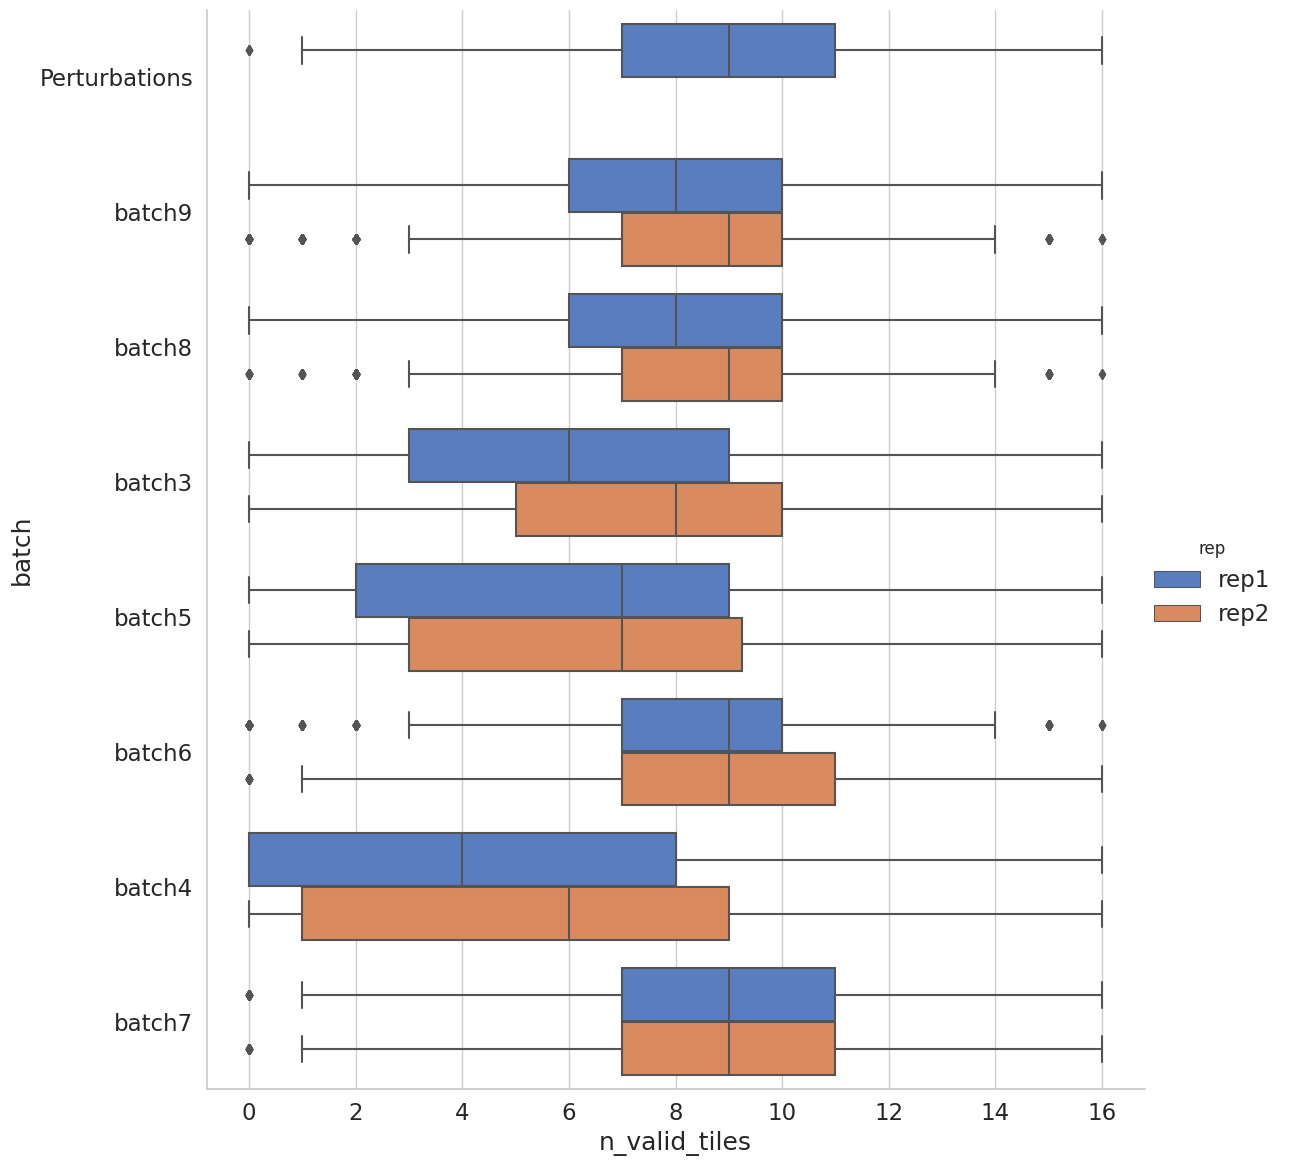

<Figure size 800x800 with 0 Axes>

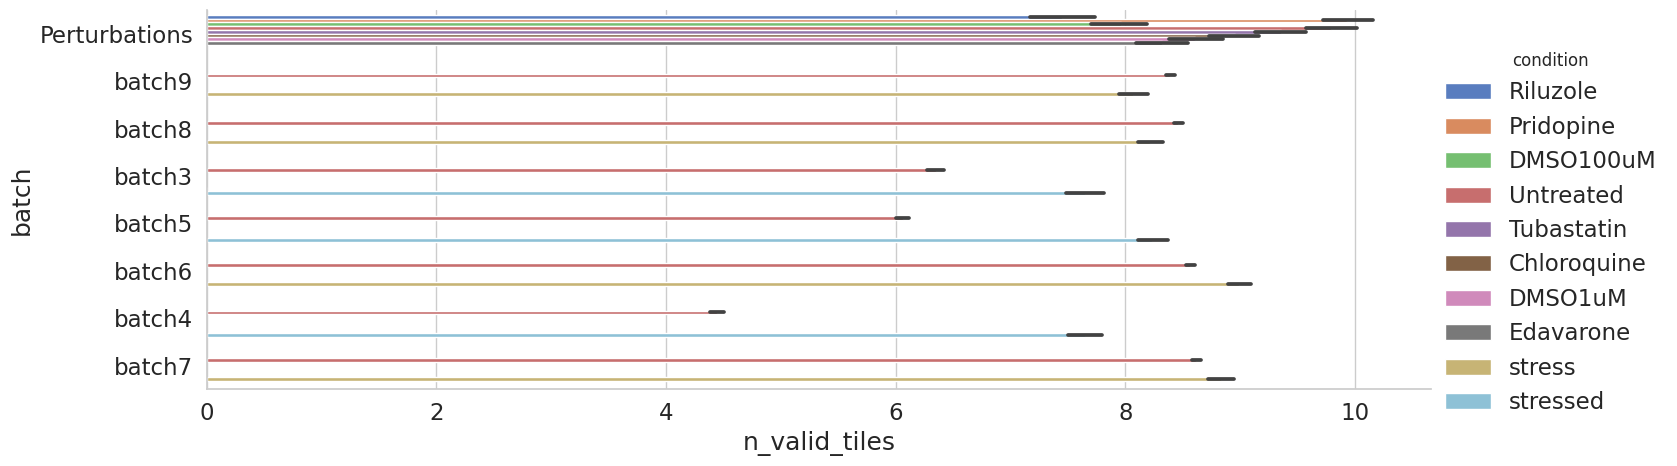

In [10]:
values = ['cells_count_mean', 'cells_count_std',
          'whole_cells_count_mean','whole_cells_count_std',
          'n_valid_tiles']

for value, c_palette in zip(values, ['pastel', 'husl', 'dark', 'deep', 'muted']):

    
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='box', data=df, y='batch', x=value, hue='rep', height=12, palette=sns.color_palette(c_palette))
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='bar', data=df, y='batch', x=value, hue='condition', aspect=3, palette=sns.color_palette(c_palette))




# <font color='grean'>Calc Statistics for valid tiles only (tiles that passed QC condition)  </font>



## <font color='purple'>Heatmap QC per batch, panel and cell line(tiles that passed QC condition)  </font>


(131317, 22)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


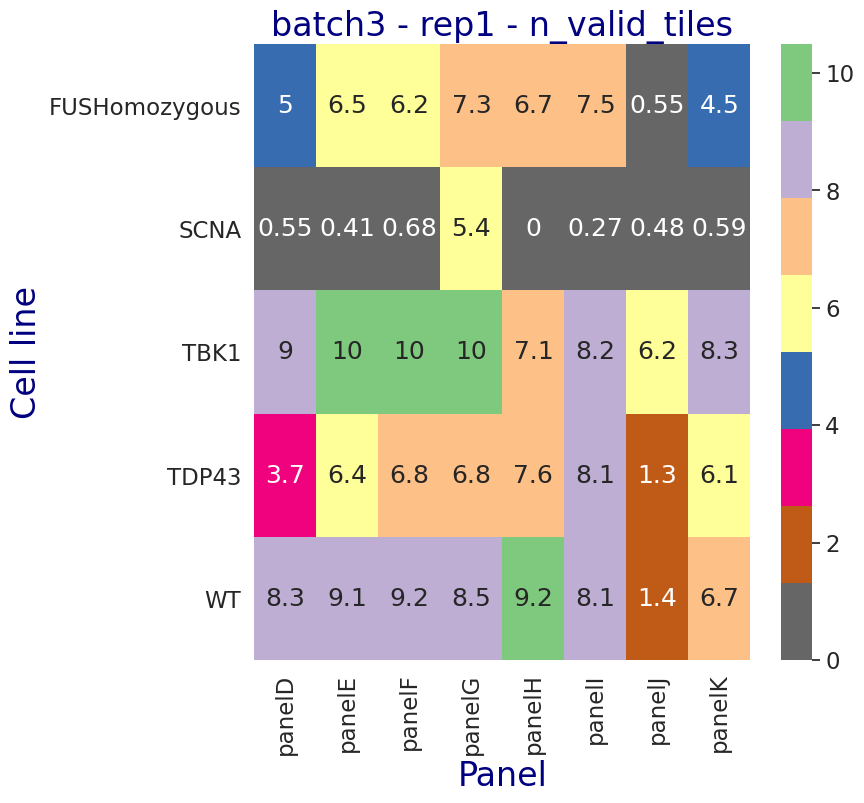

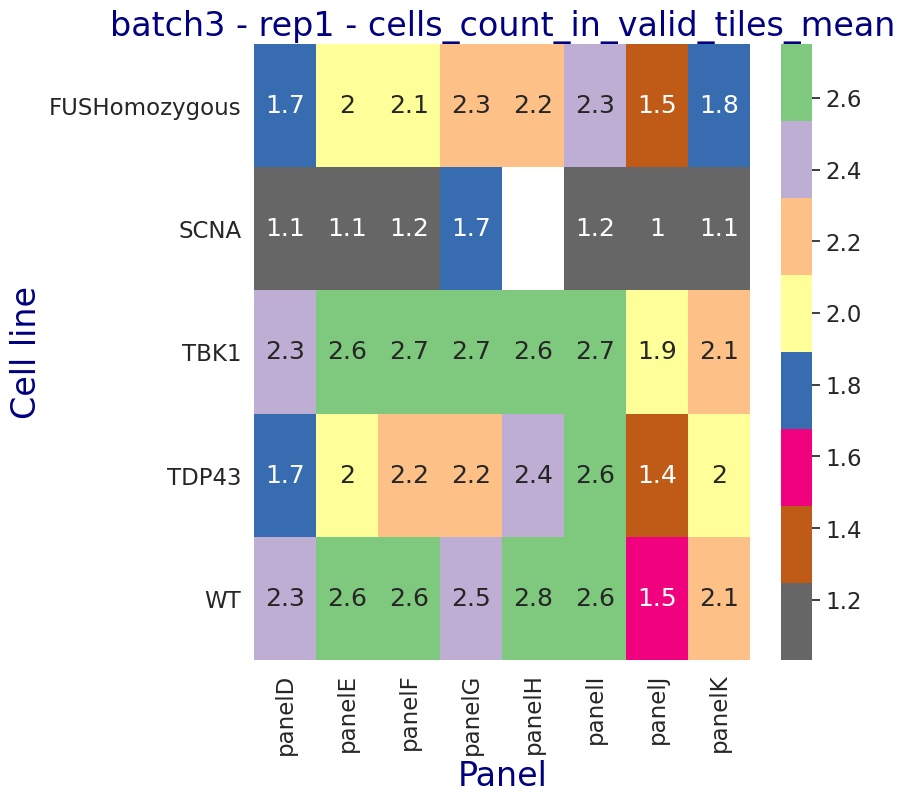

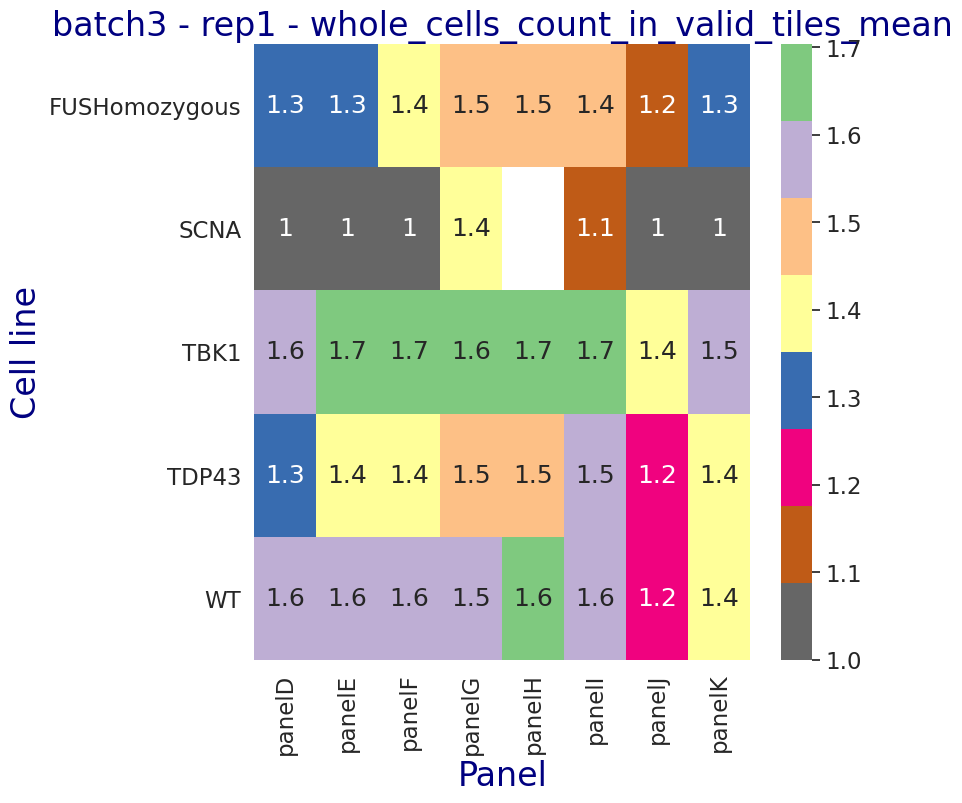

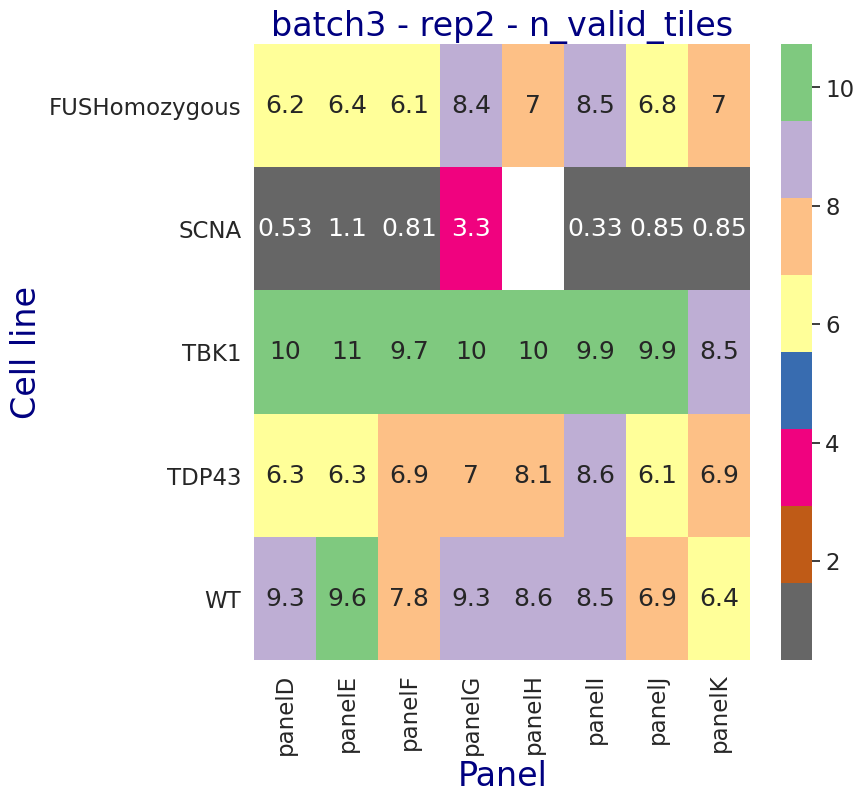

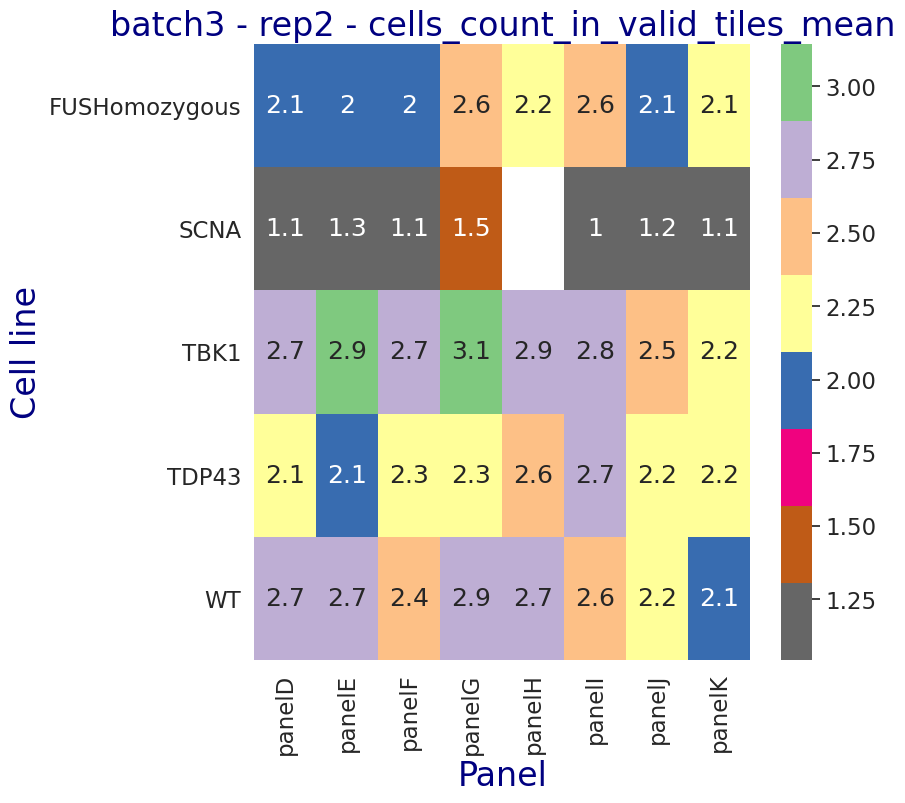

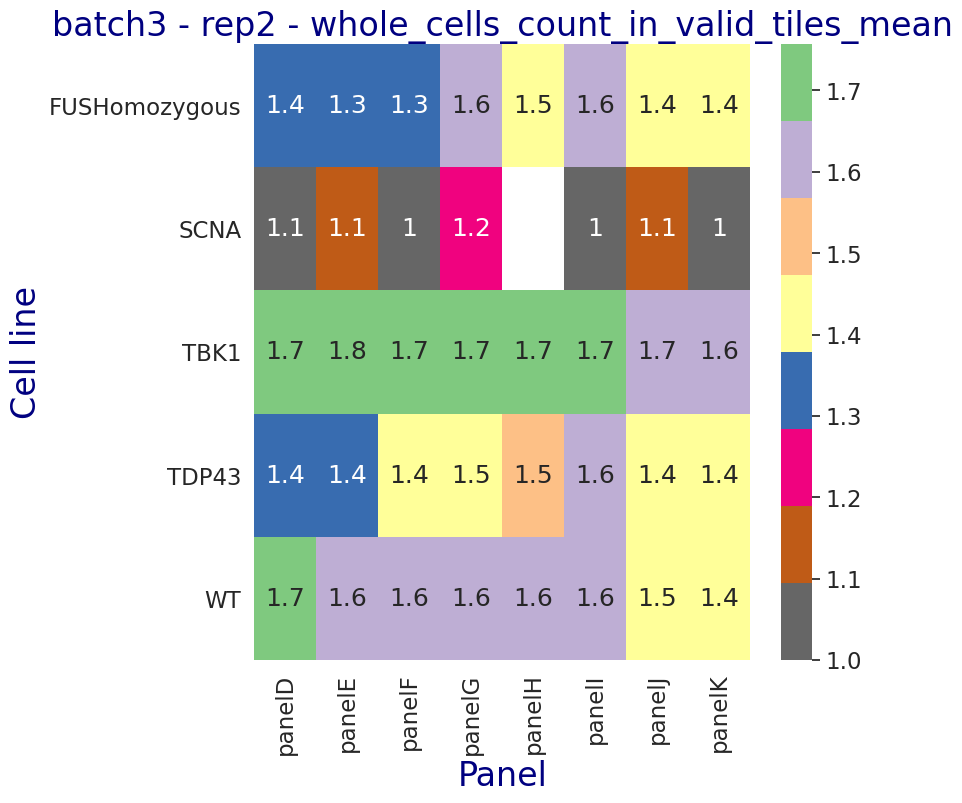

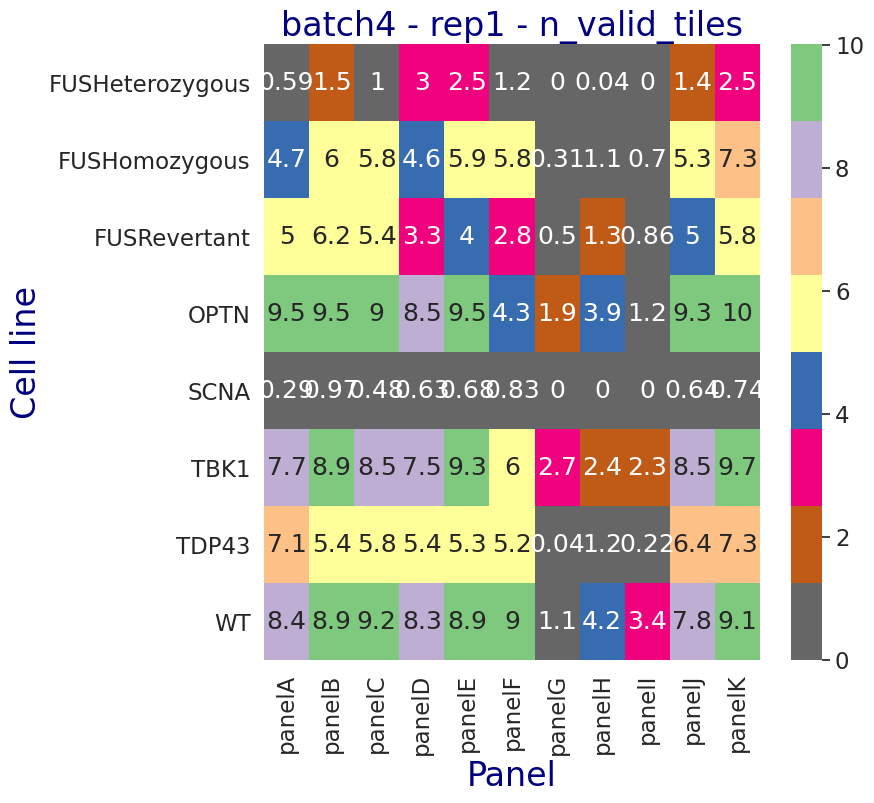

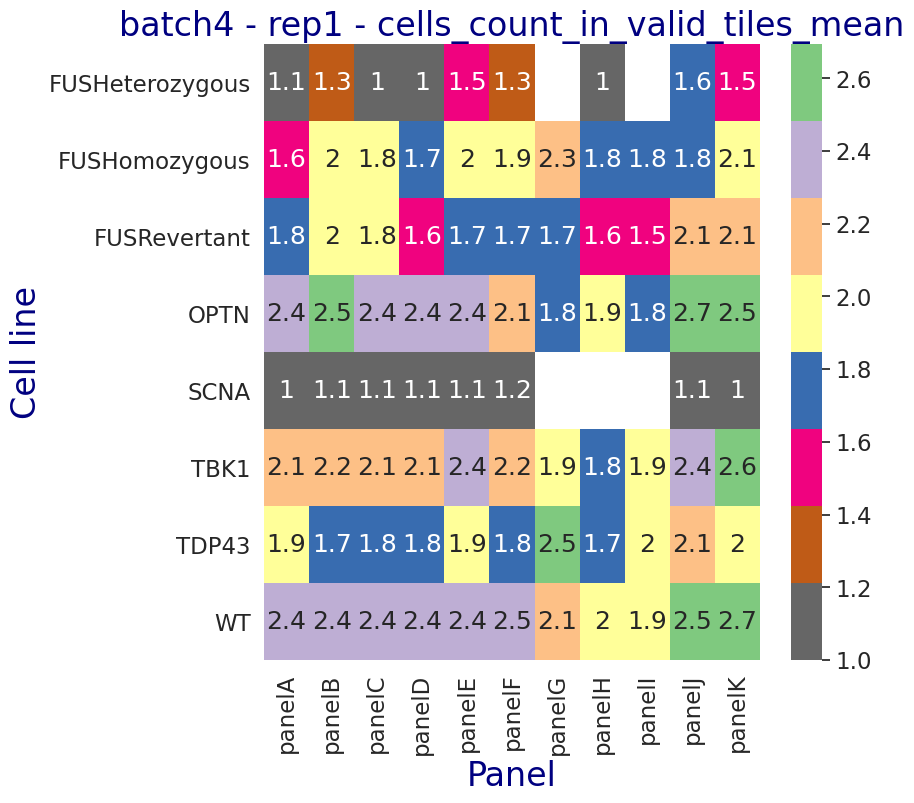

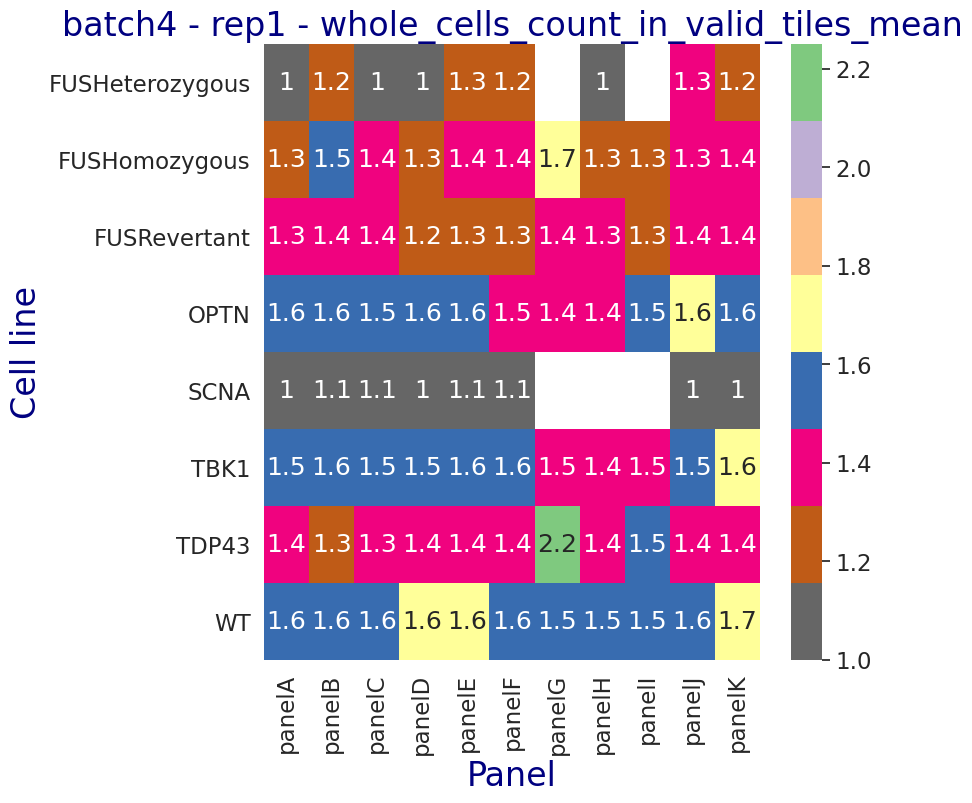

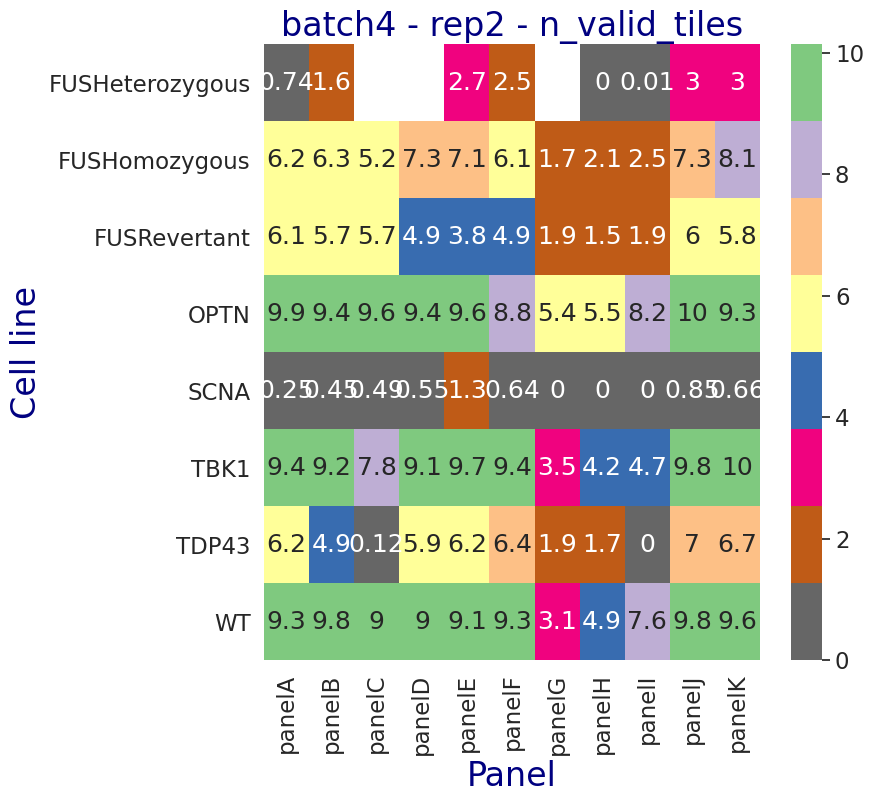

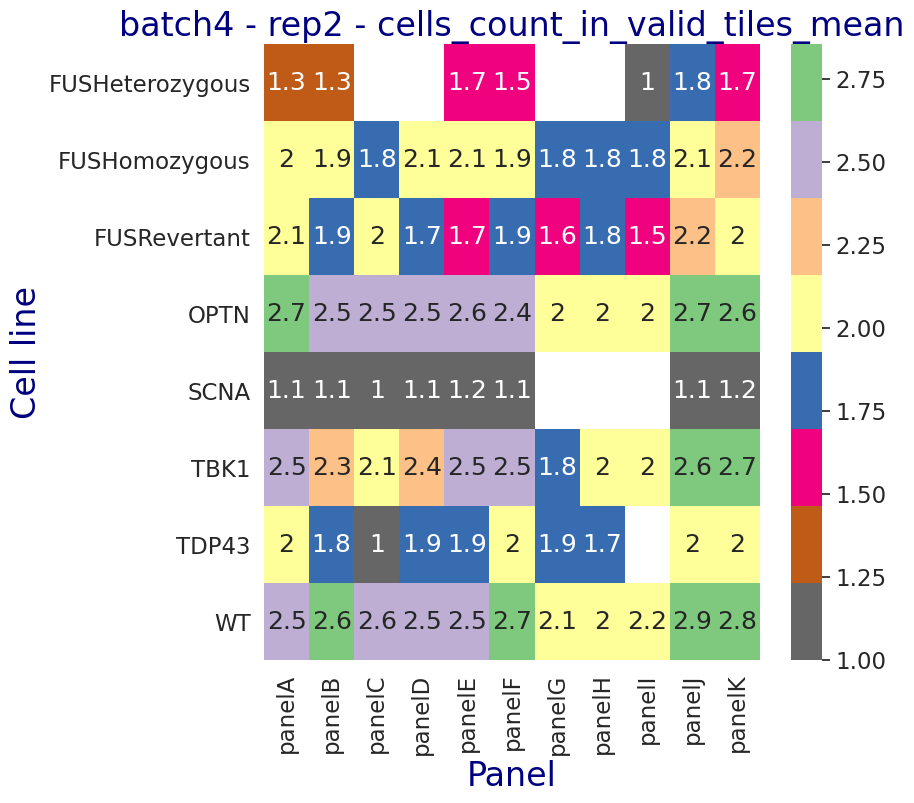

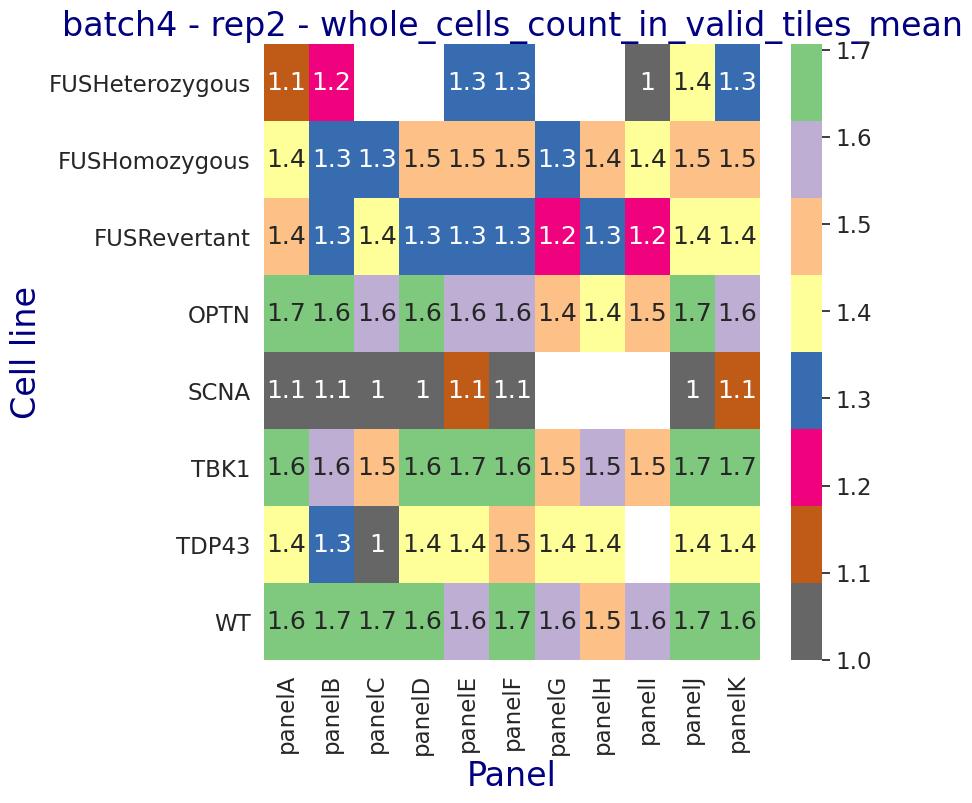

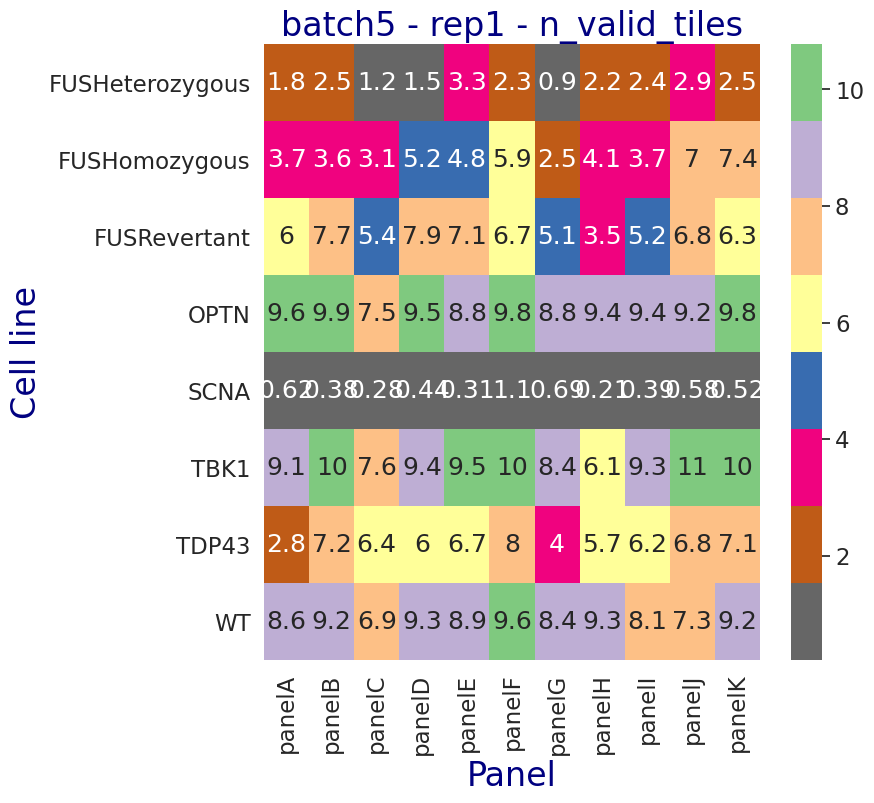

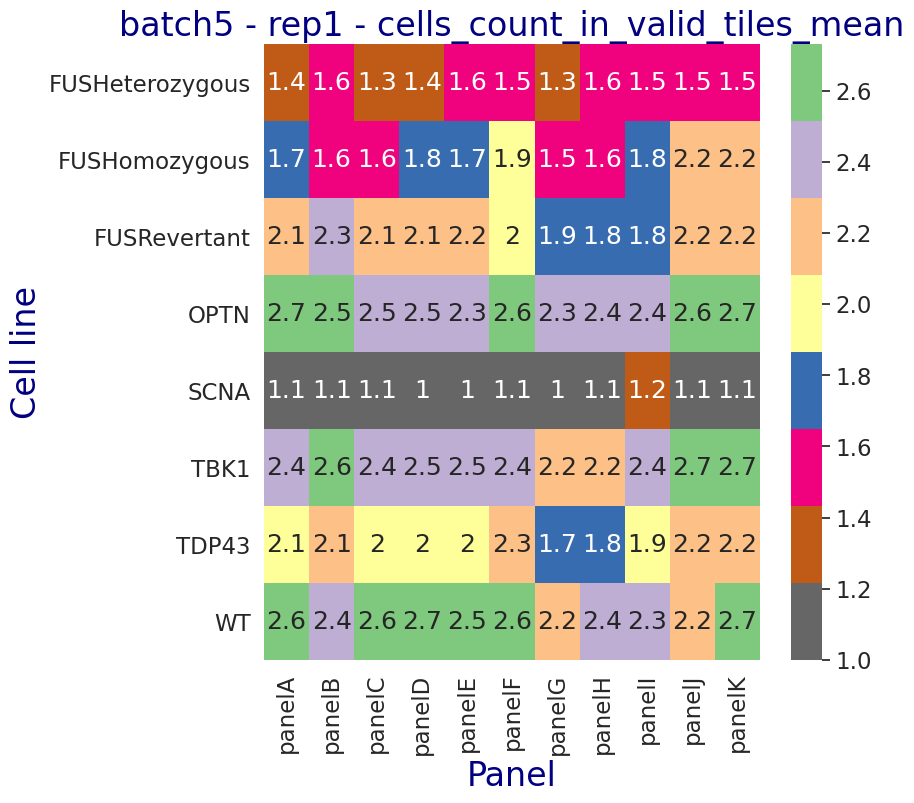

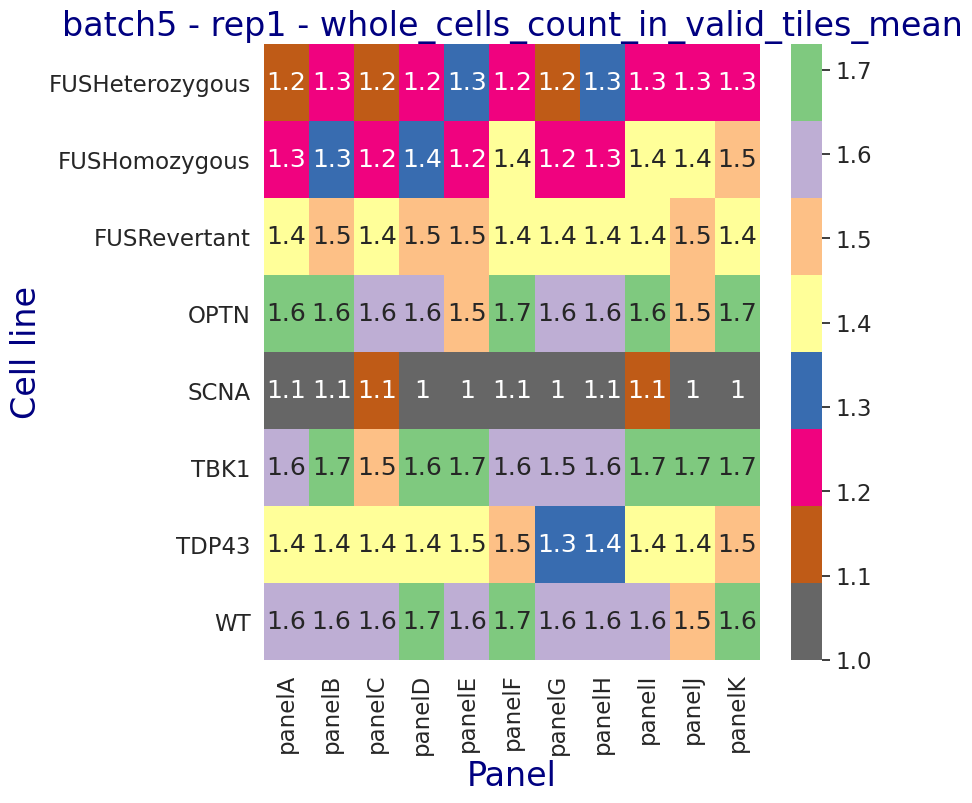

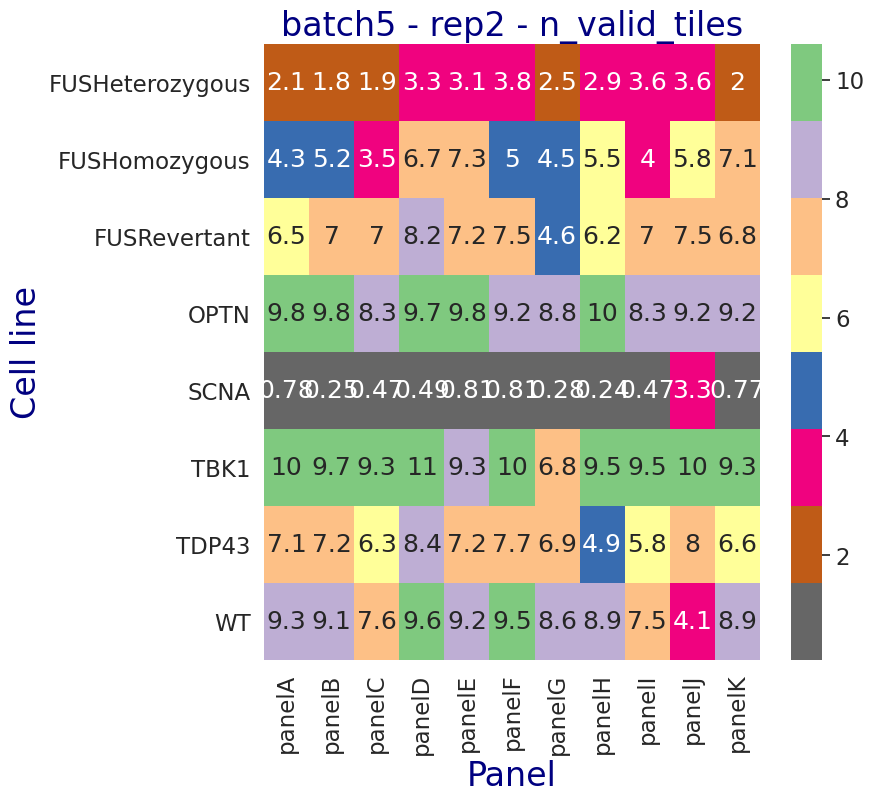

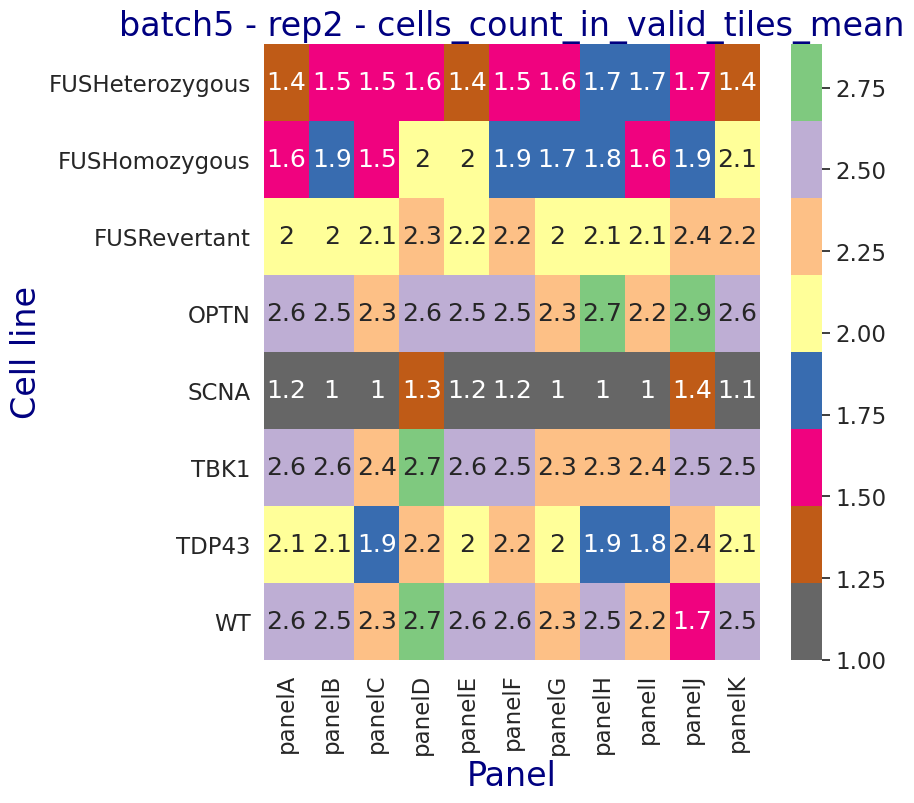

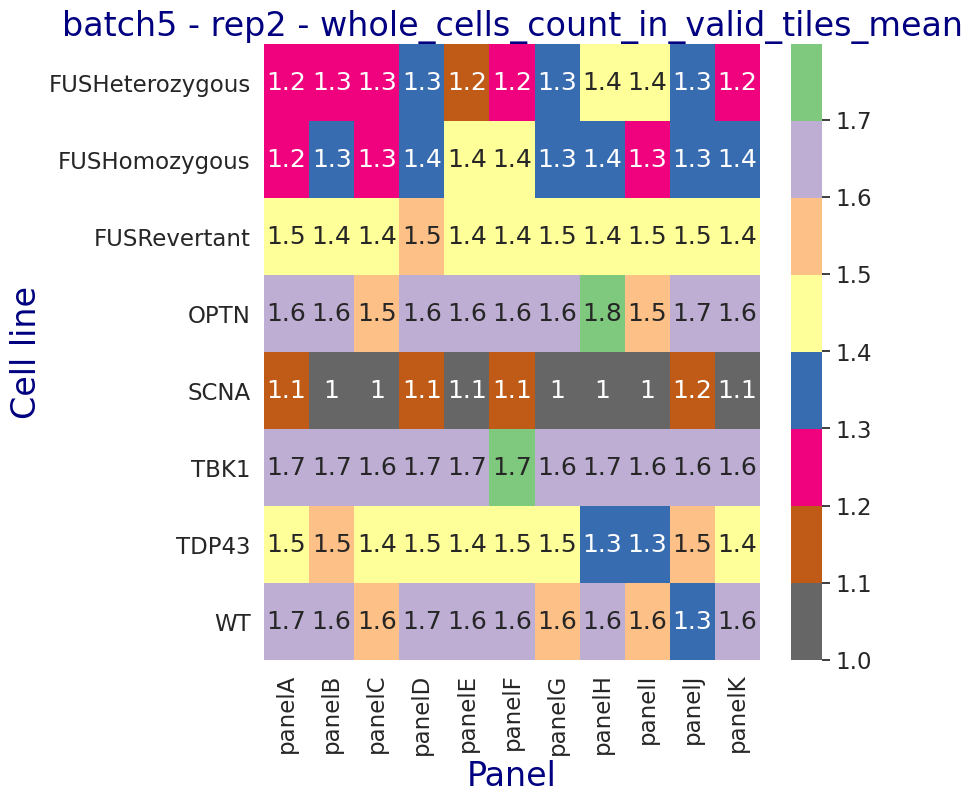

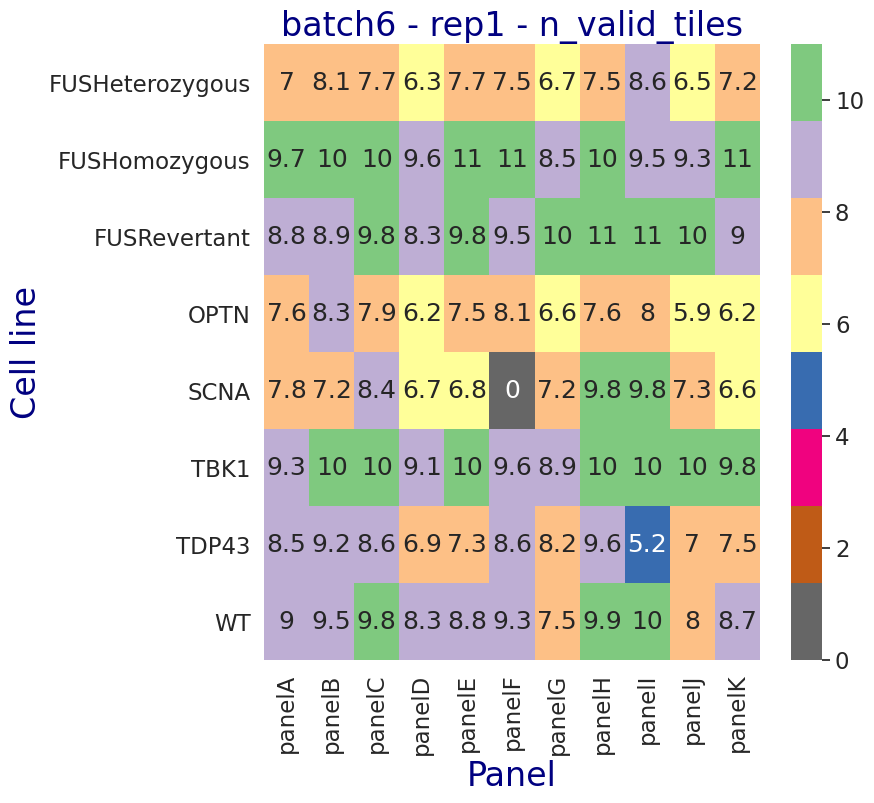

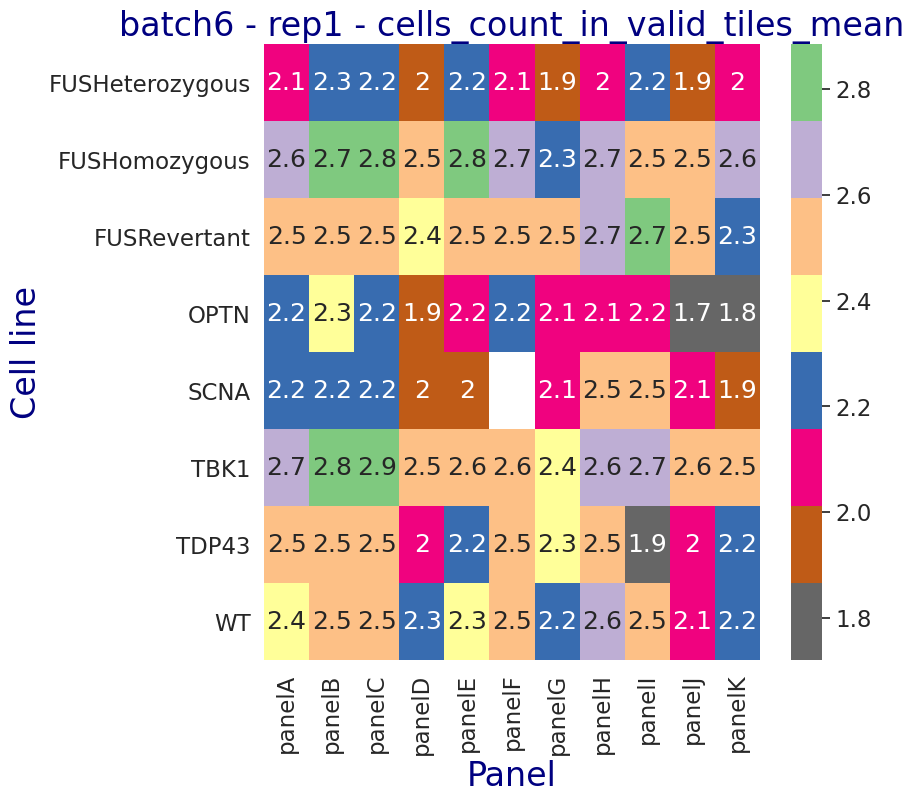

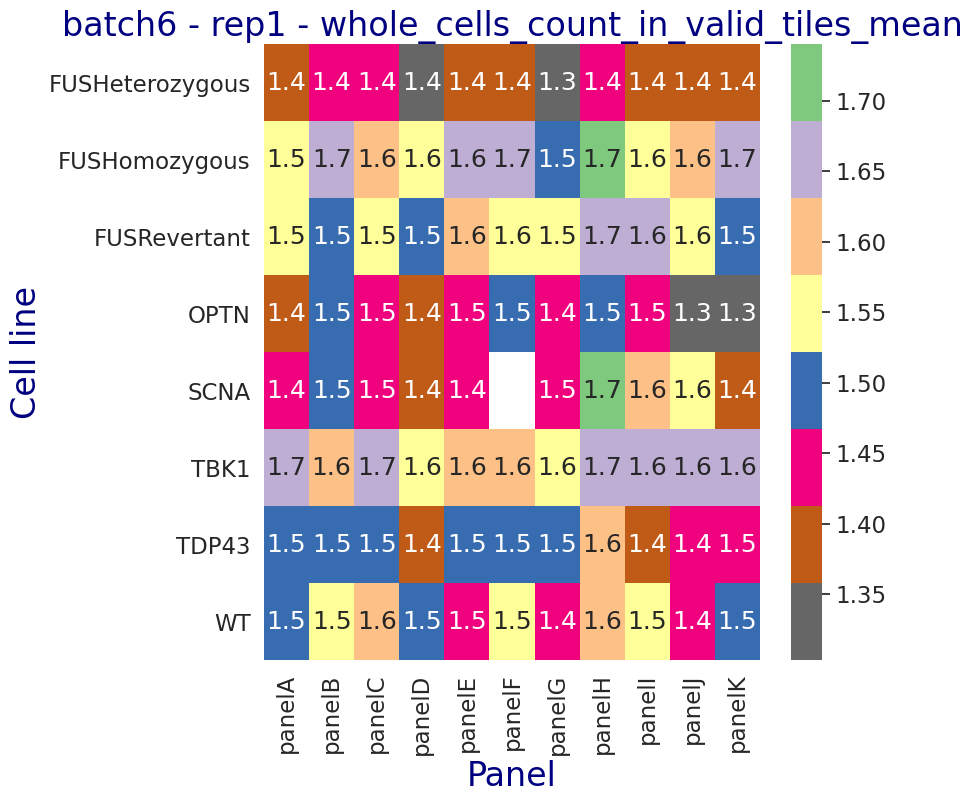

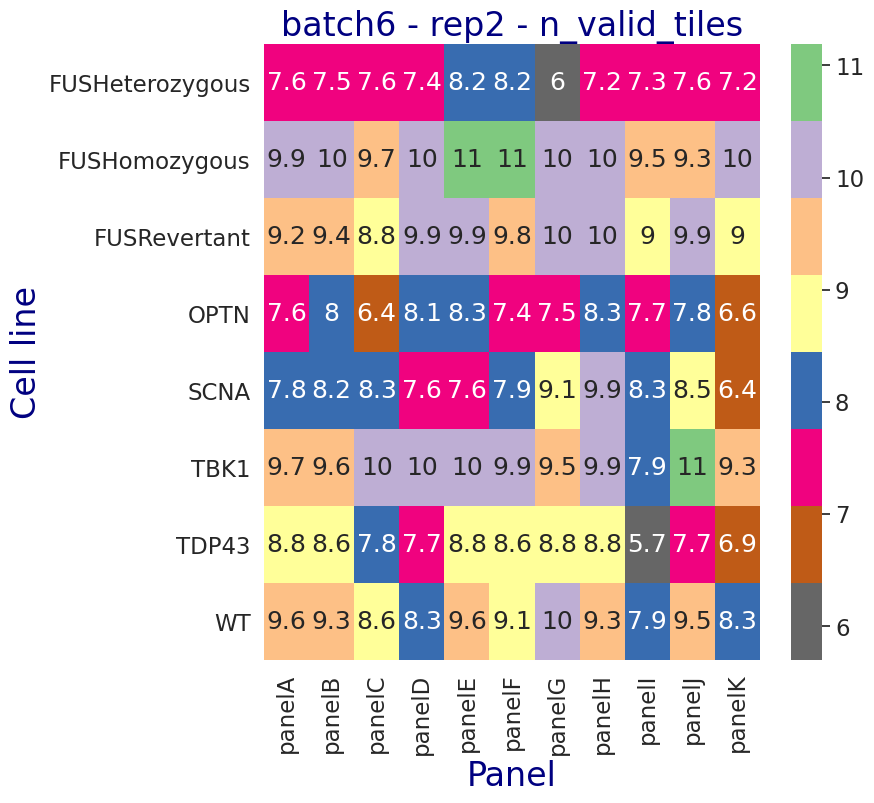

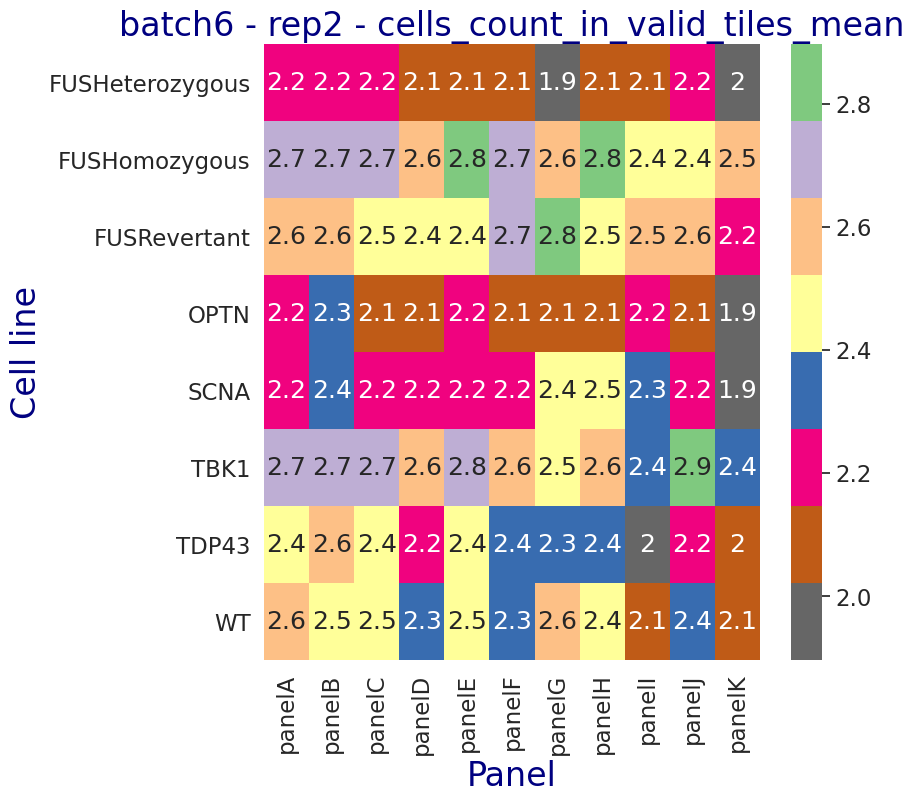

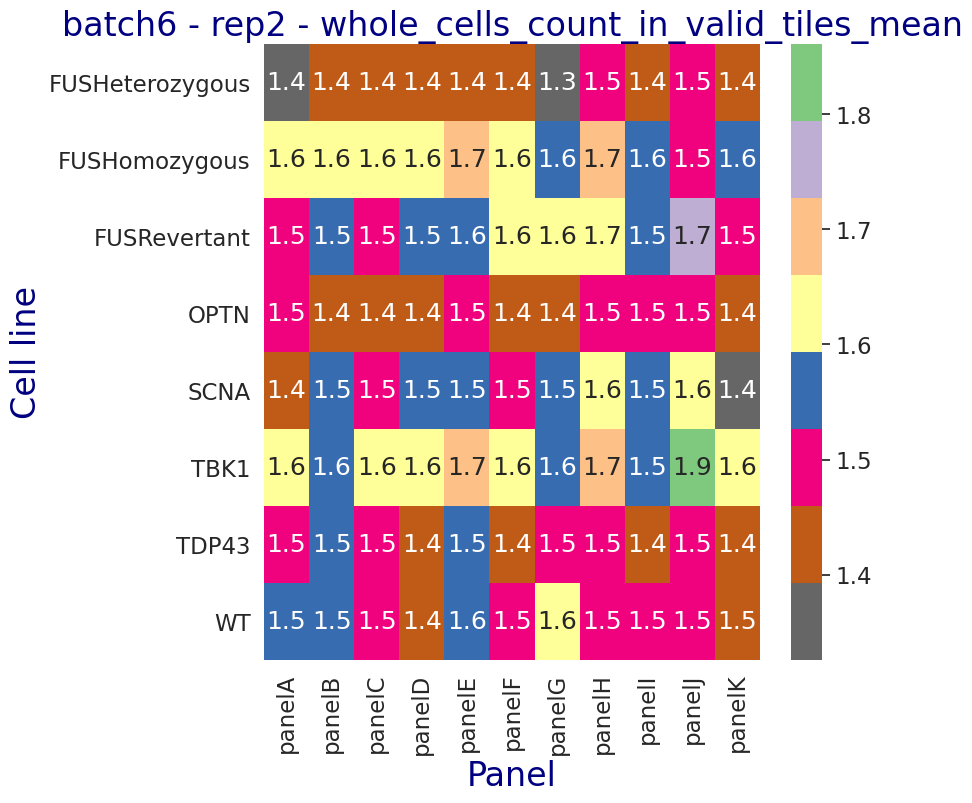

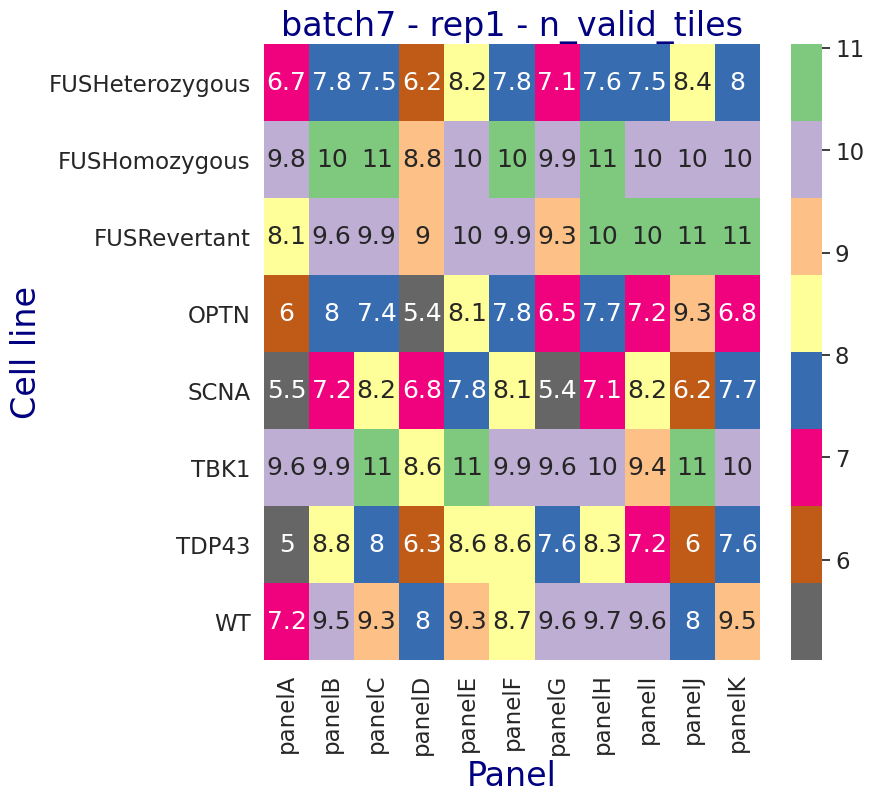

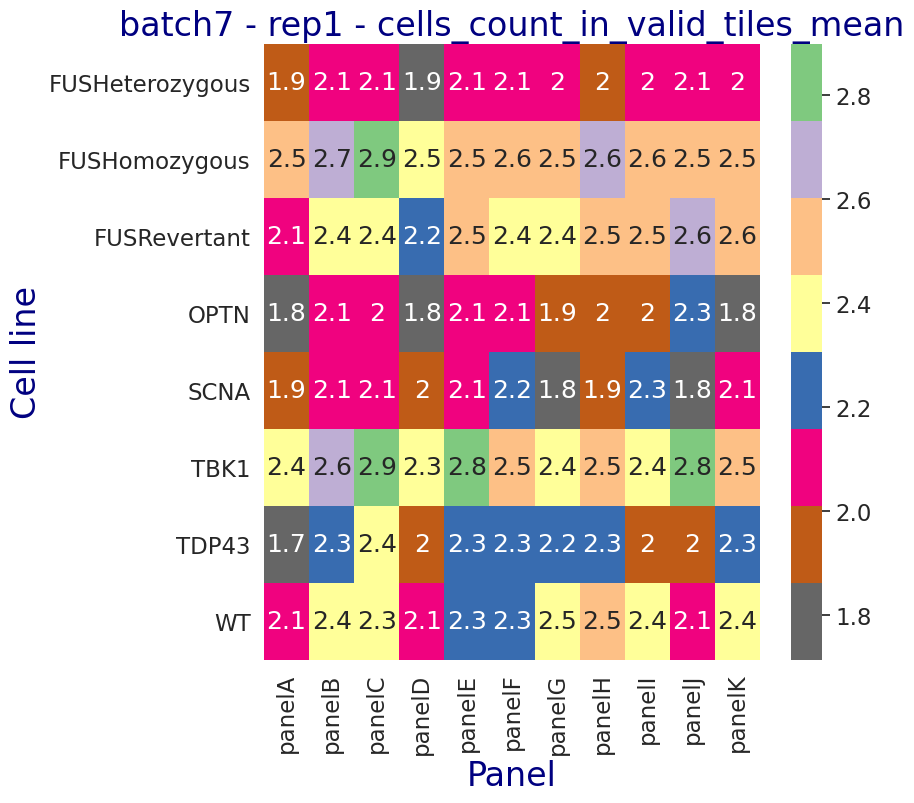

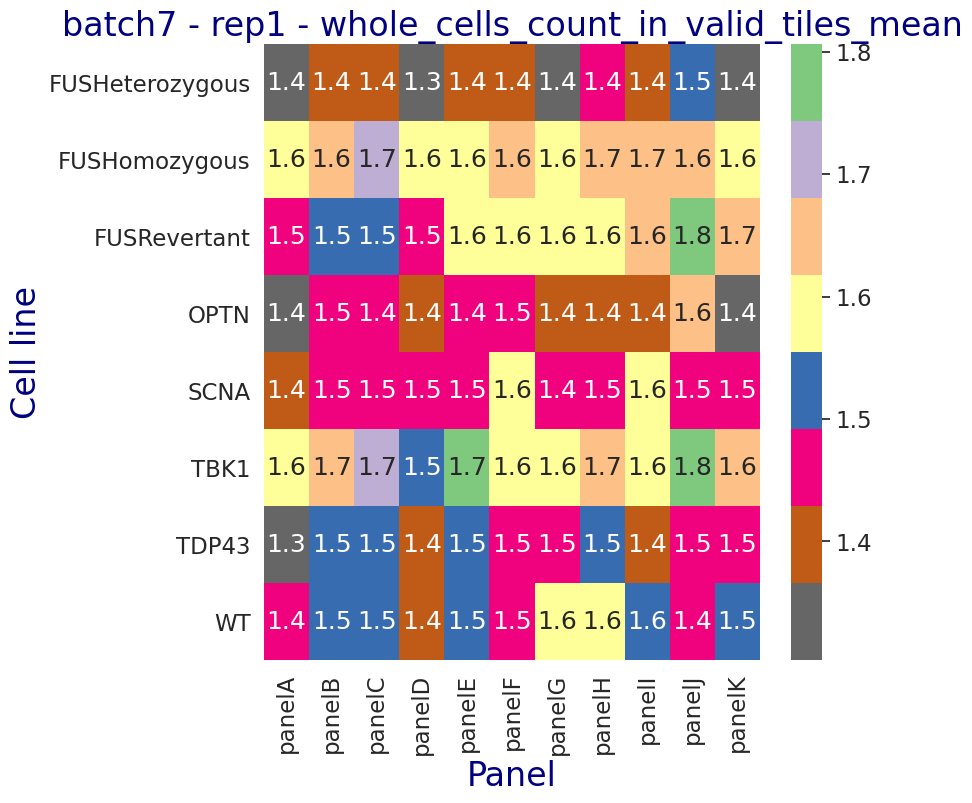

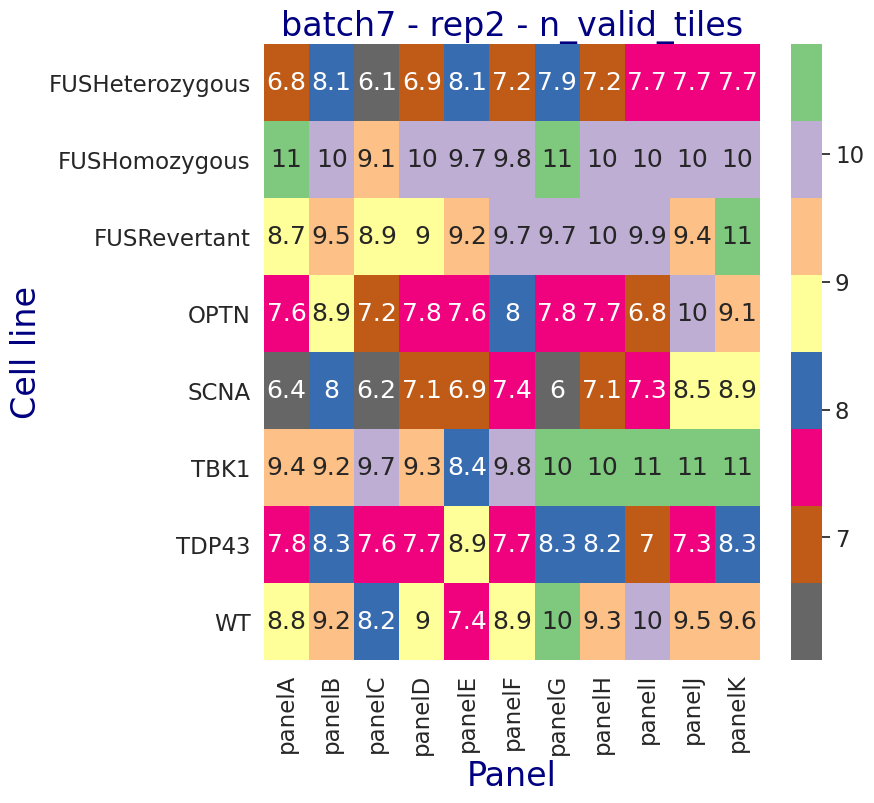

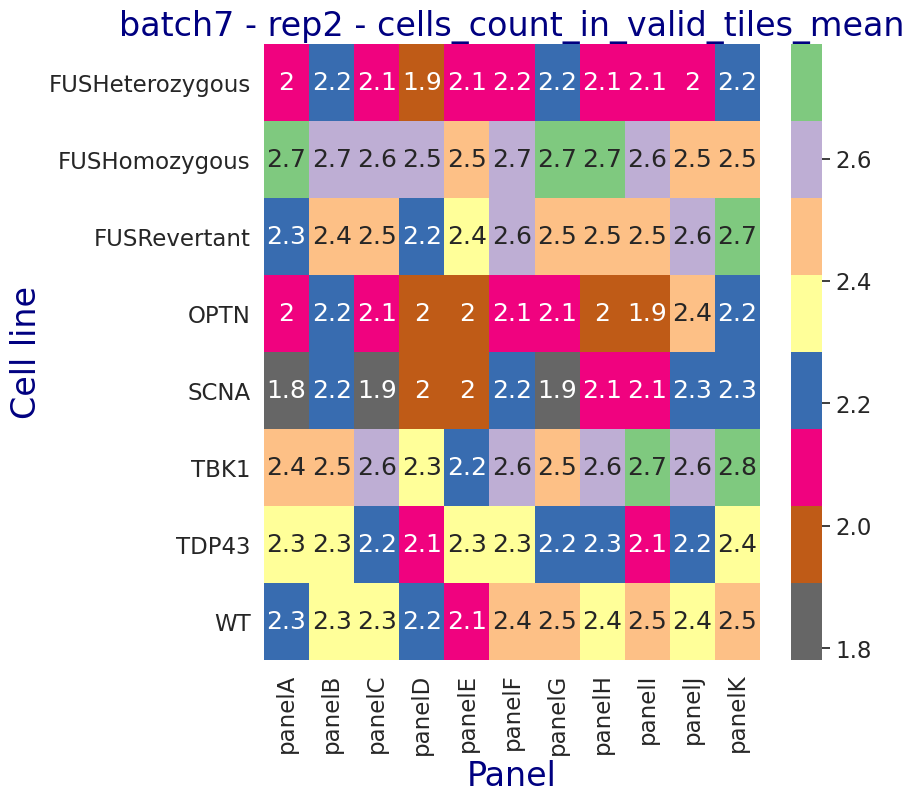

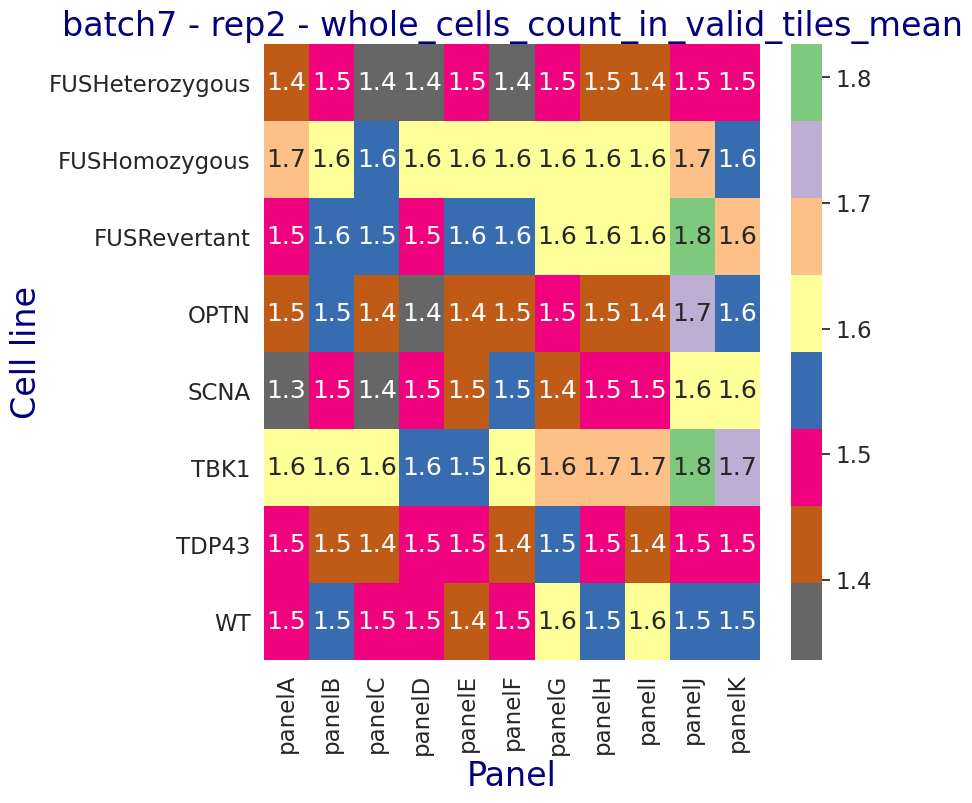

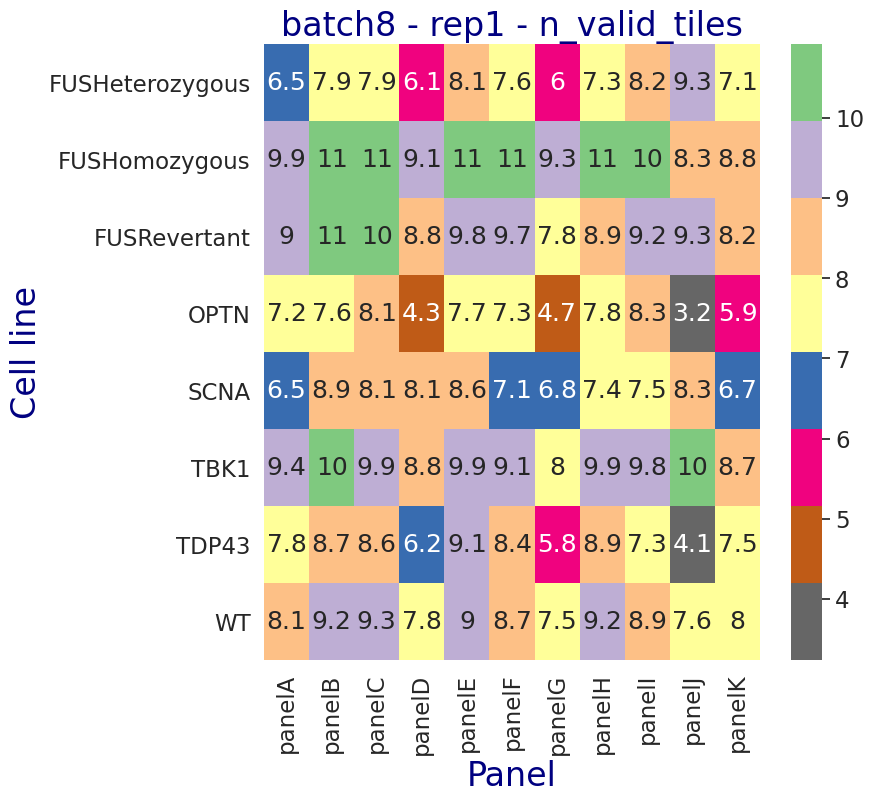

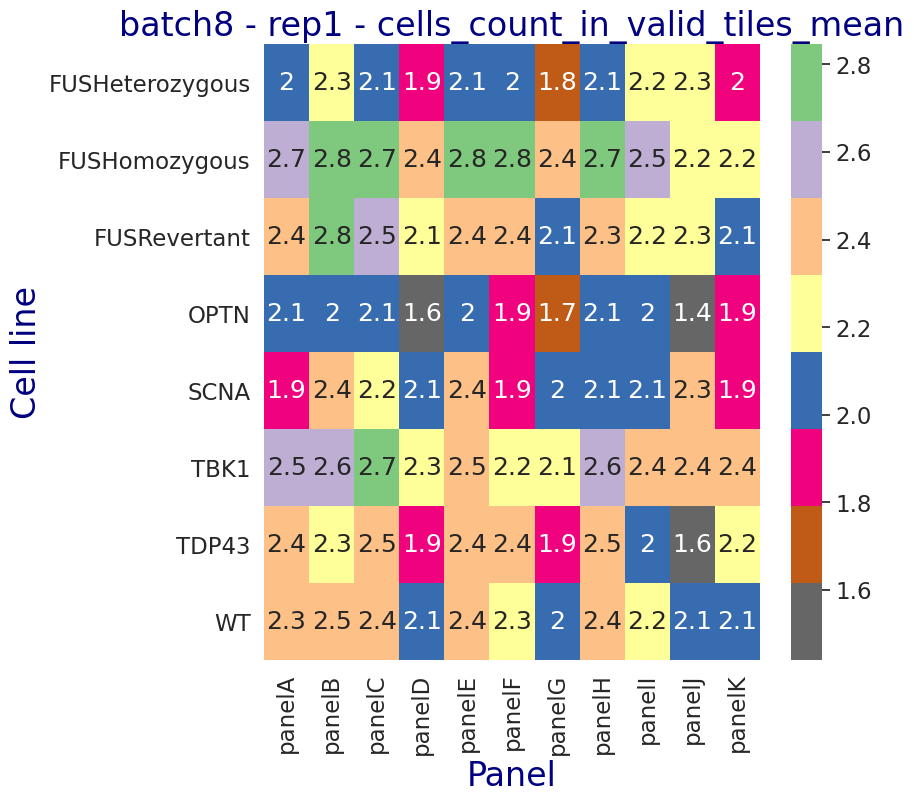

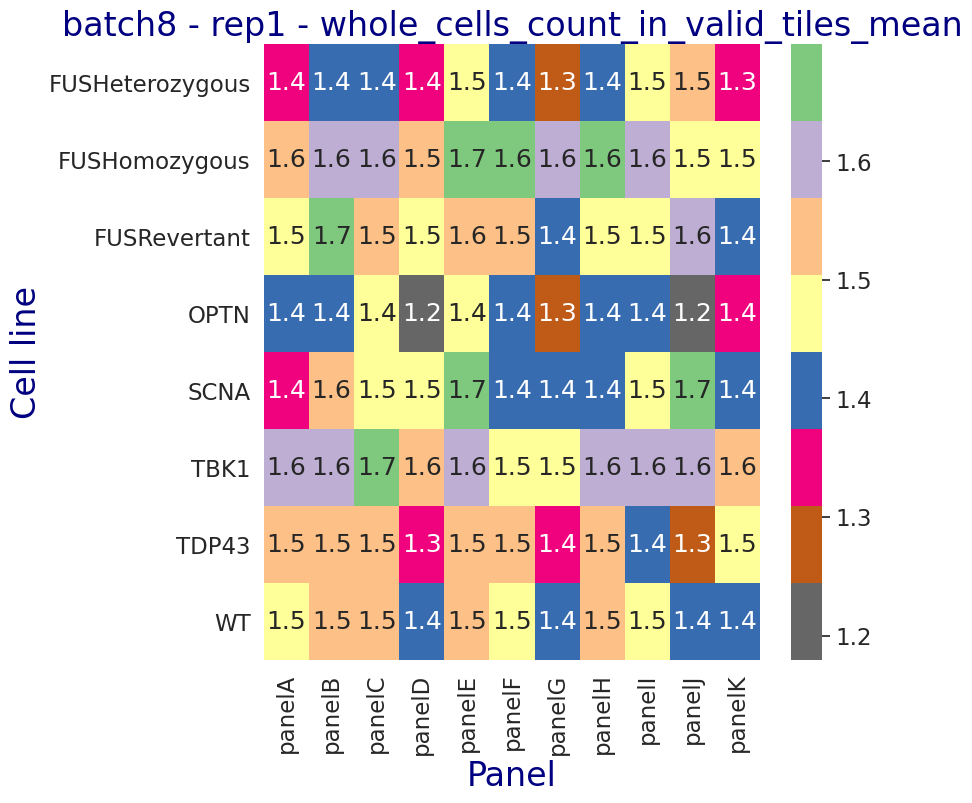

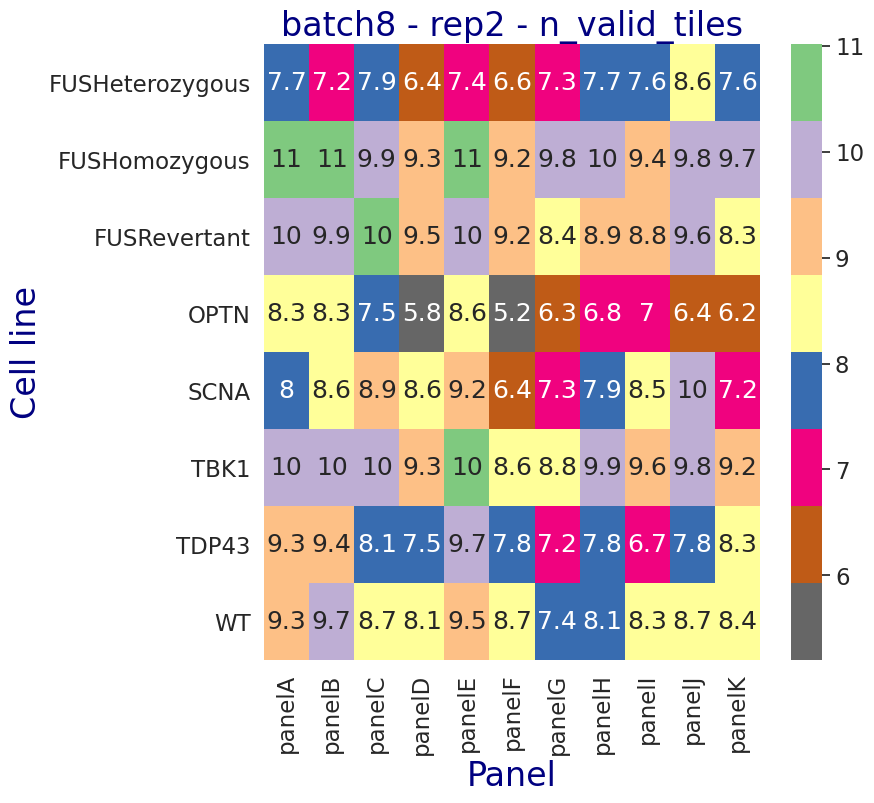

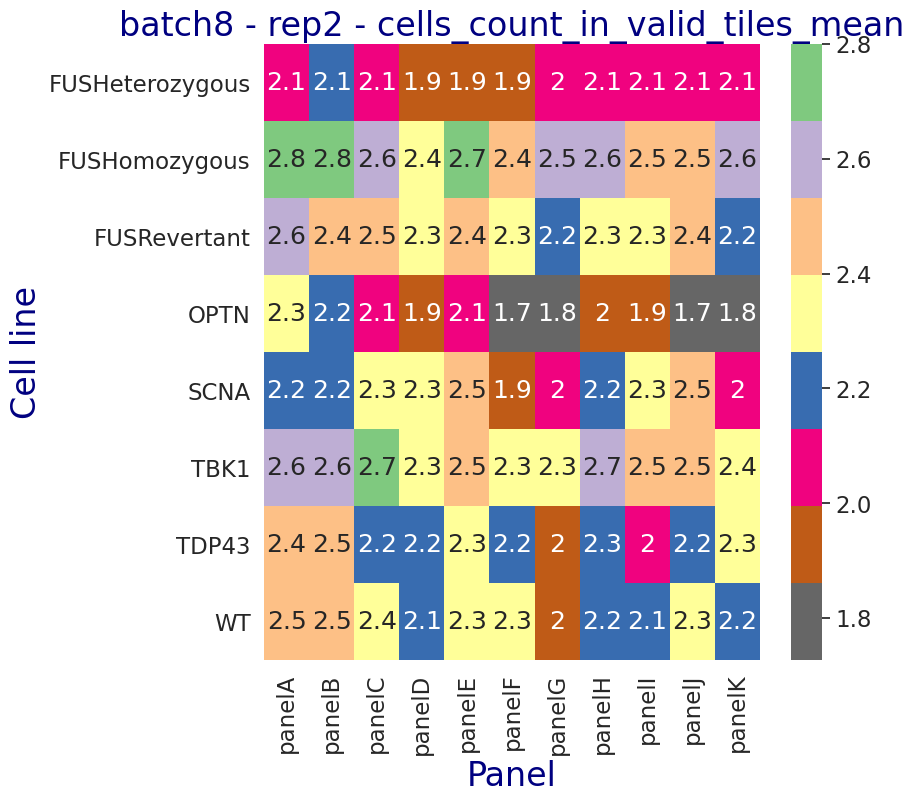

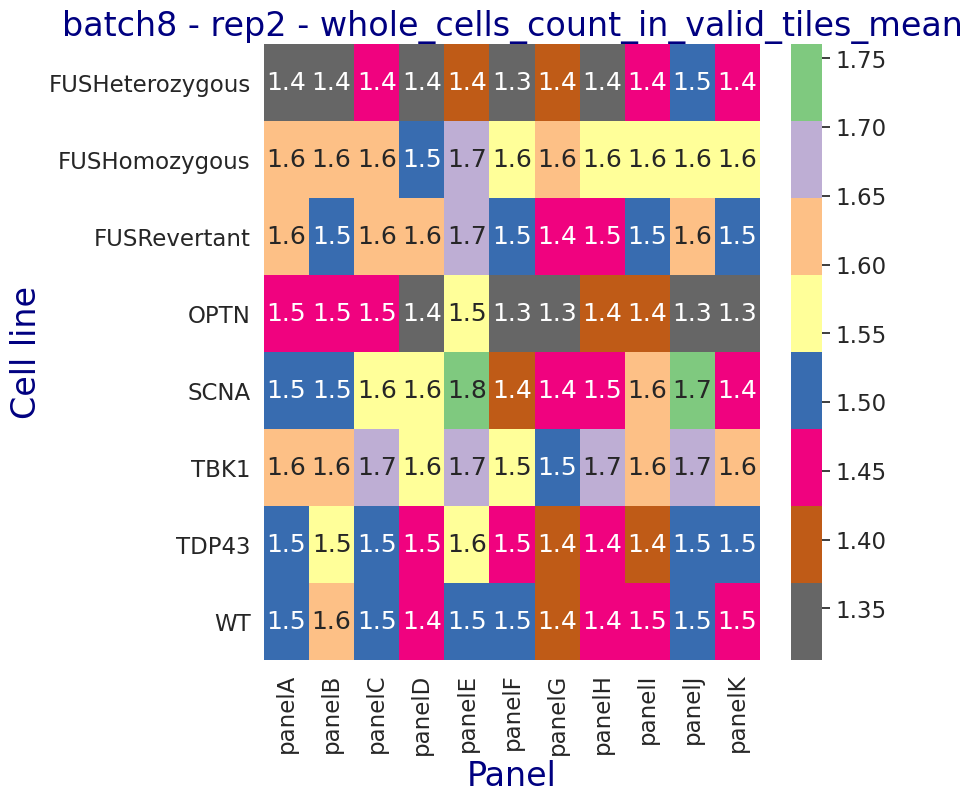

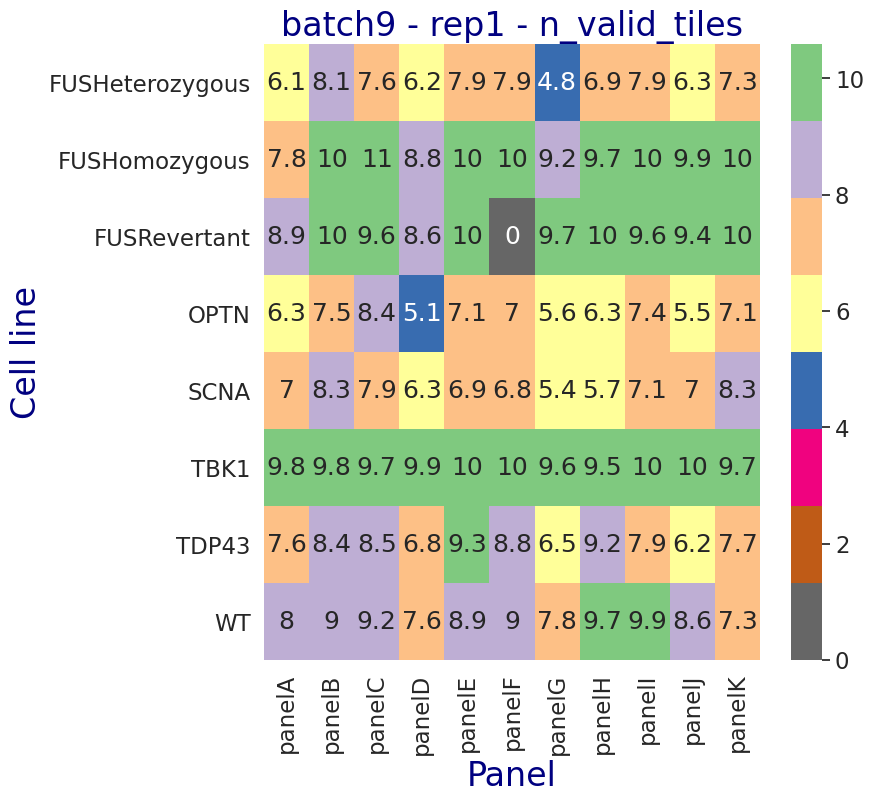

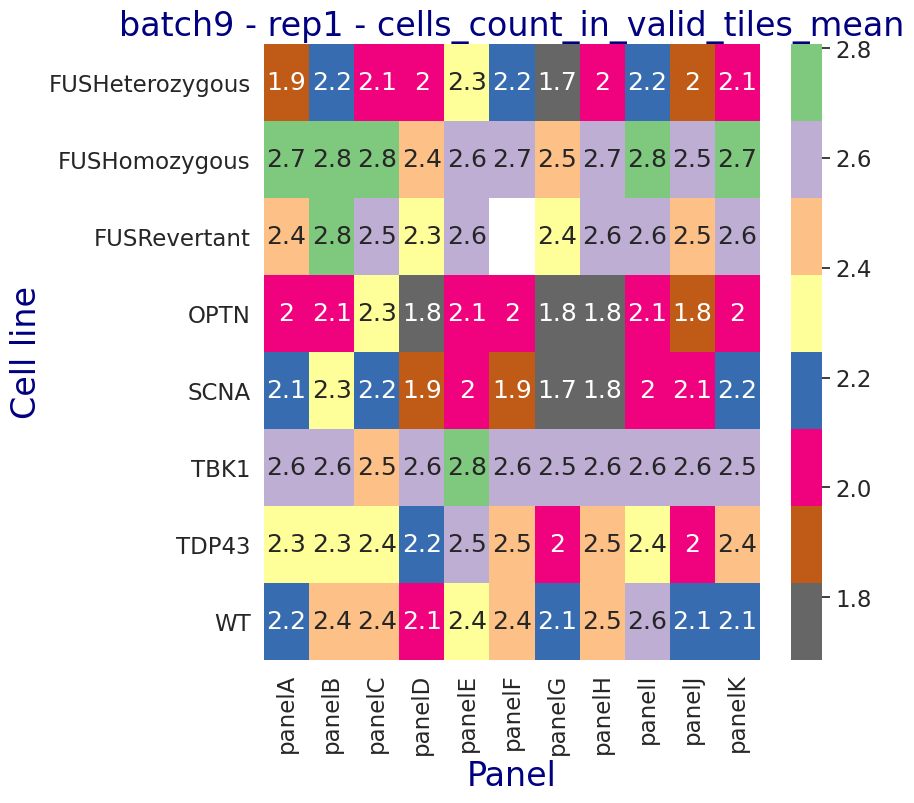

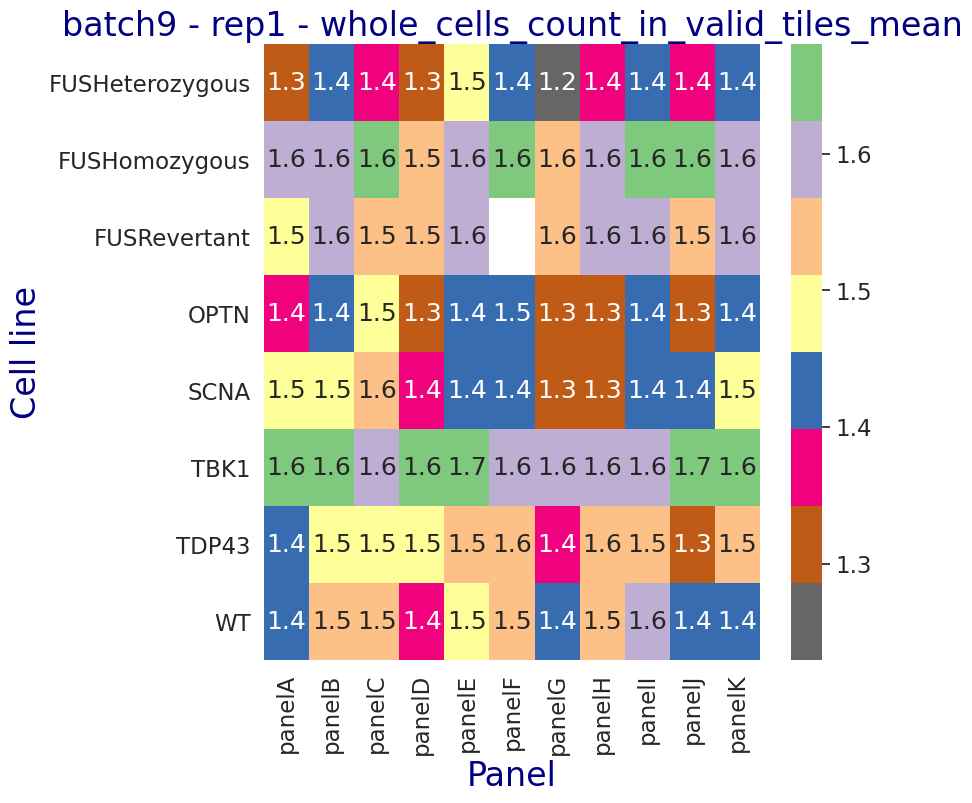

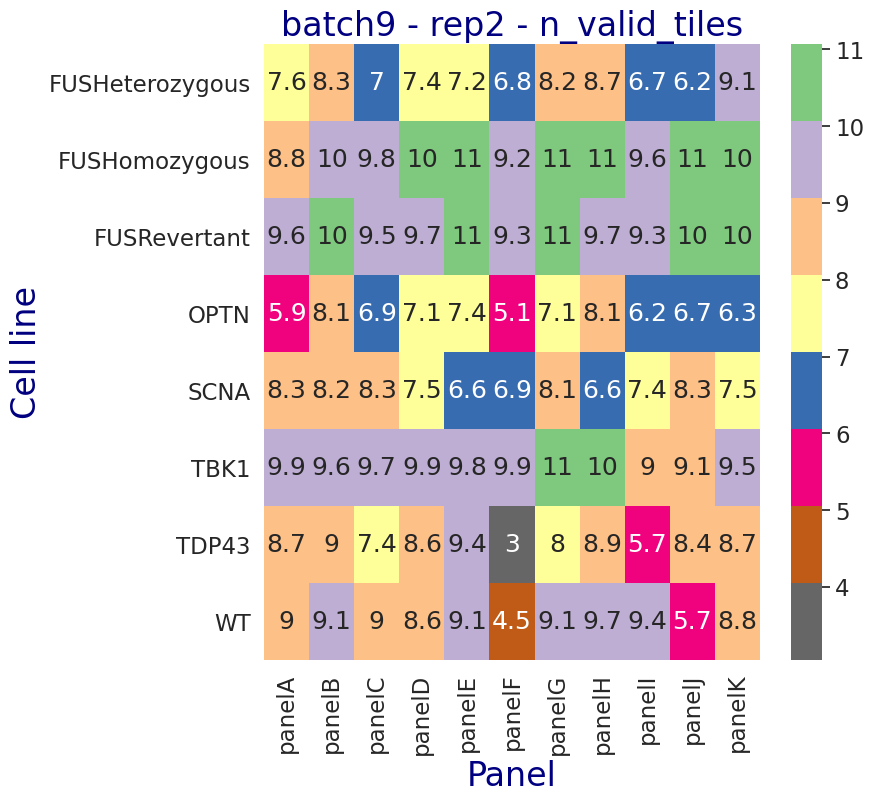

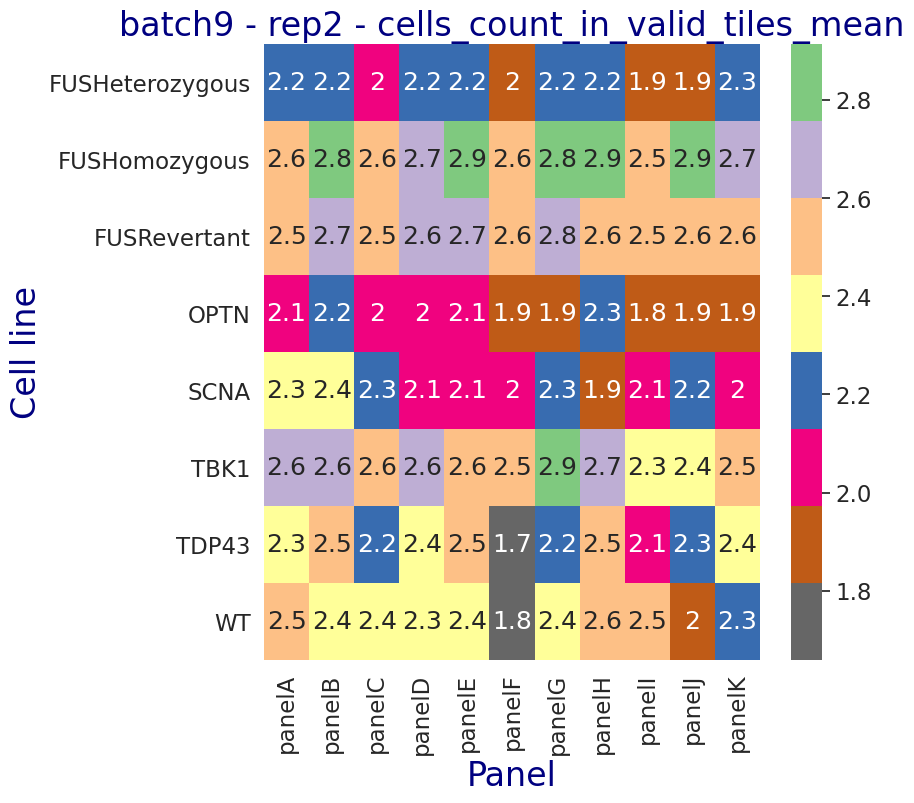

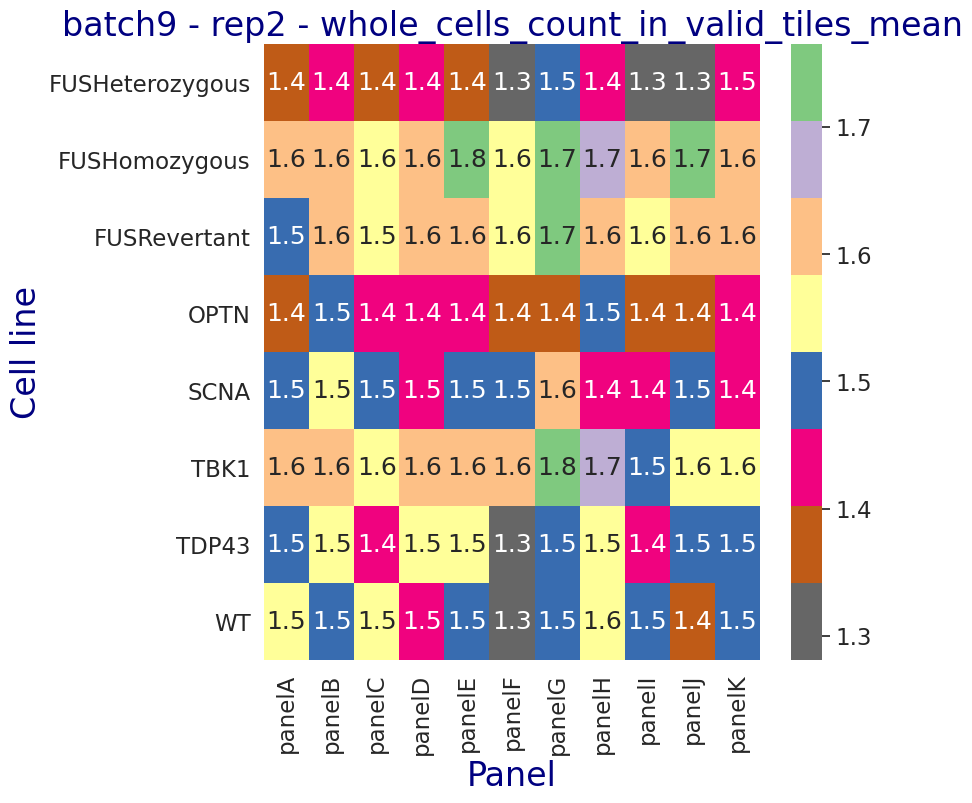

In [31]:
batchs = np.sort(df['batch'].unique())
reps = np.sort(df['rep'].unique())
for batch in batchs:
    for rep in reps:
        
        # Get relevant sub-set of the data
        df_batch = df[(df['batch']==batch) & ((df['rep']==rep))]
        
        for value in ['n_valid_tiles', 'cells_count_in_valid_tiles_mean', 'whole_cells_count_in_valid_tiles_mean']:

            plt.figure(figsize=(8,8))
            a = pd.crosstab(df_batch['cell_line'], df_batch['panel'], values=df_batch[value], aggfunc=np.mean)
            sns.heatmap(a, annot=True, cmap="flare_r")
            plt.title(batch + " - " + rep + " - " + value, fontsize=24, color="navy")
            plt.xlabel("Panel", fontsize=24, color="navy")
            plt.ylabel("Cell line", fontsize=24, color="navy")
        




<Figure size 800x800 with 0 Axes>

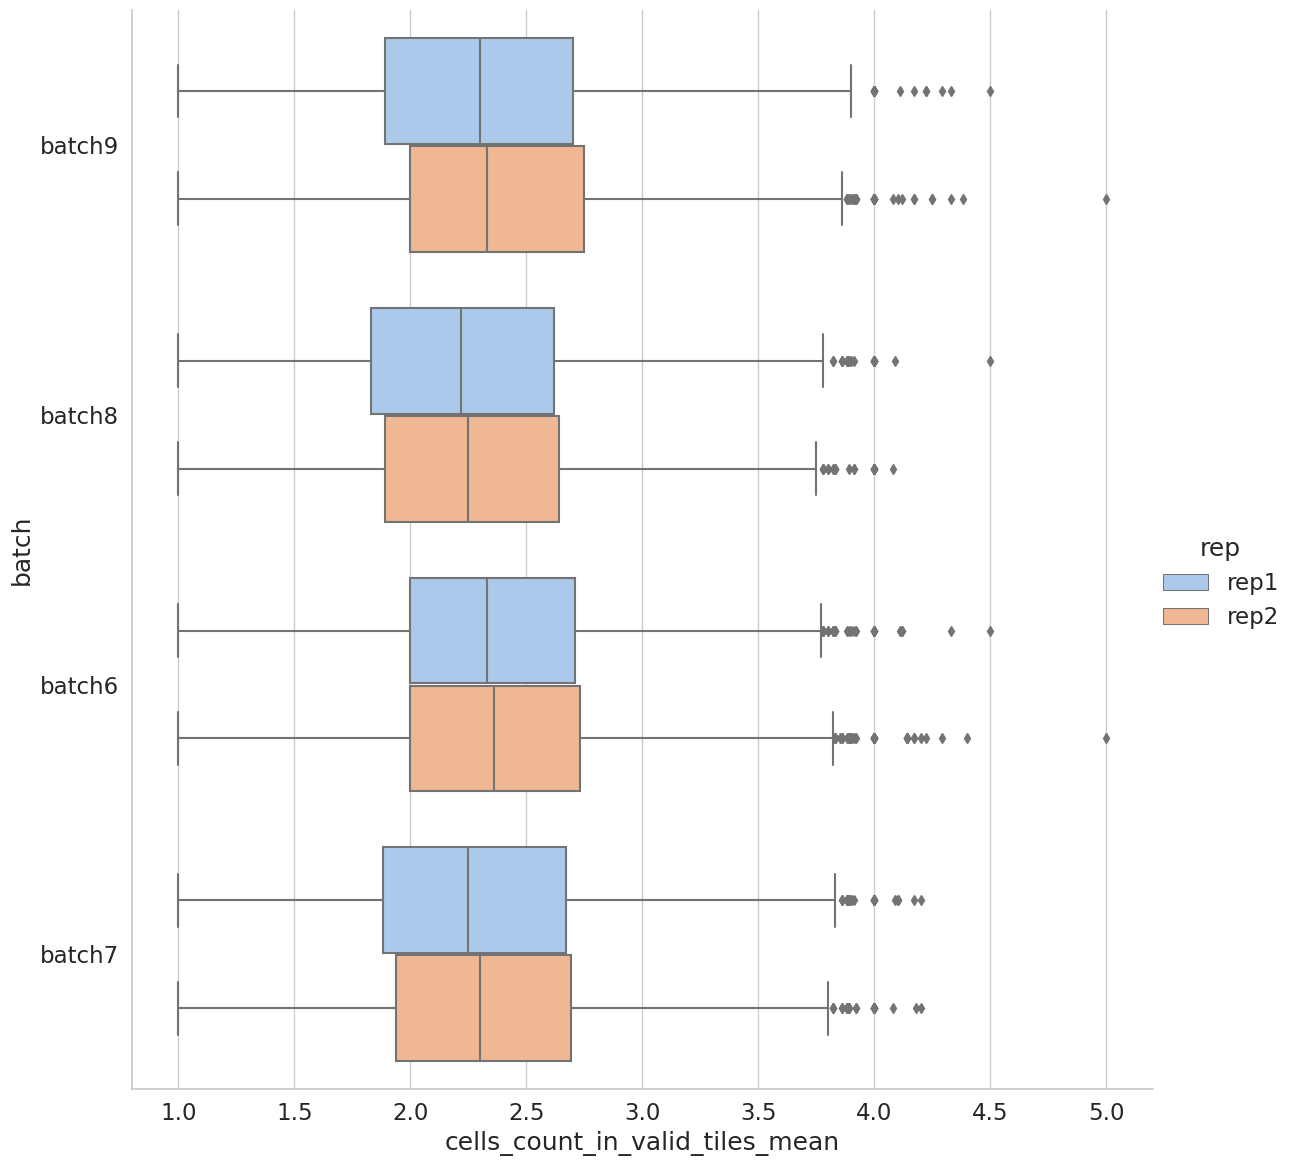

<Figure size 800x800 with 0 Axes>

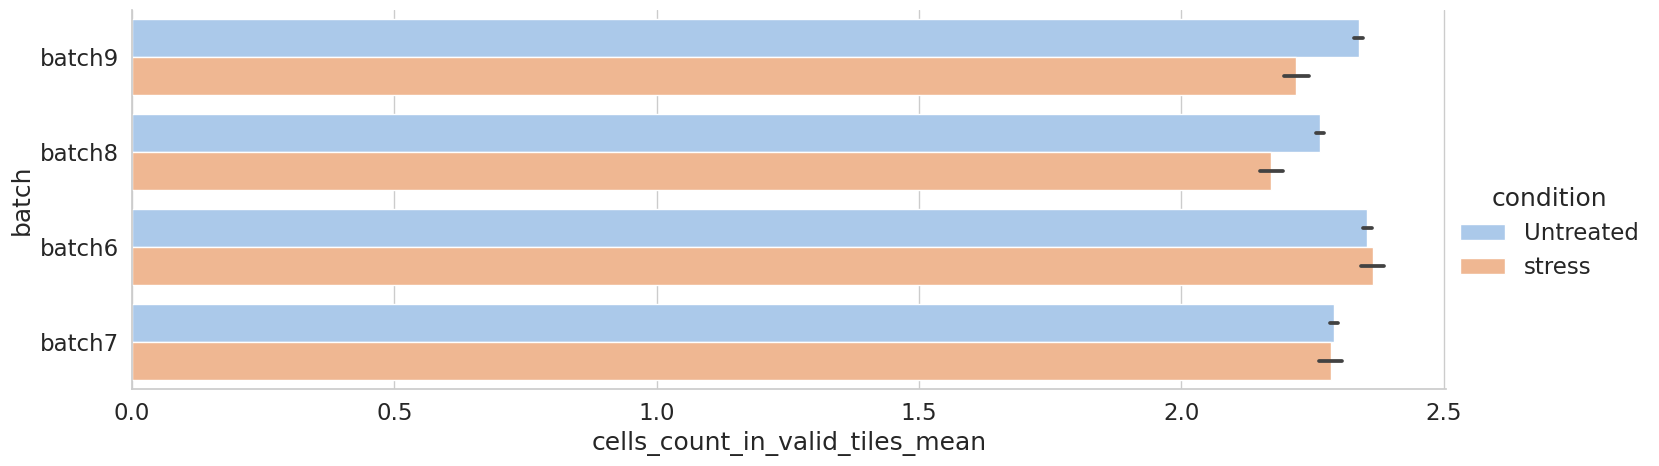

<Figure size 800x800 with 0 Axes>

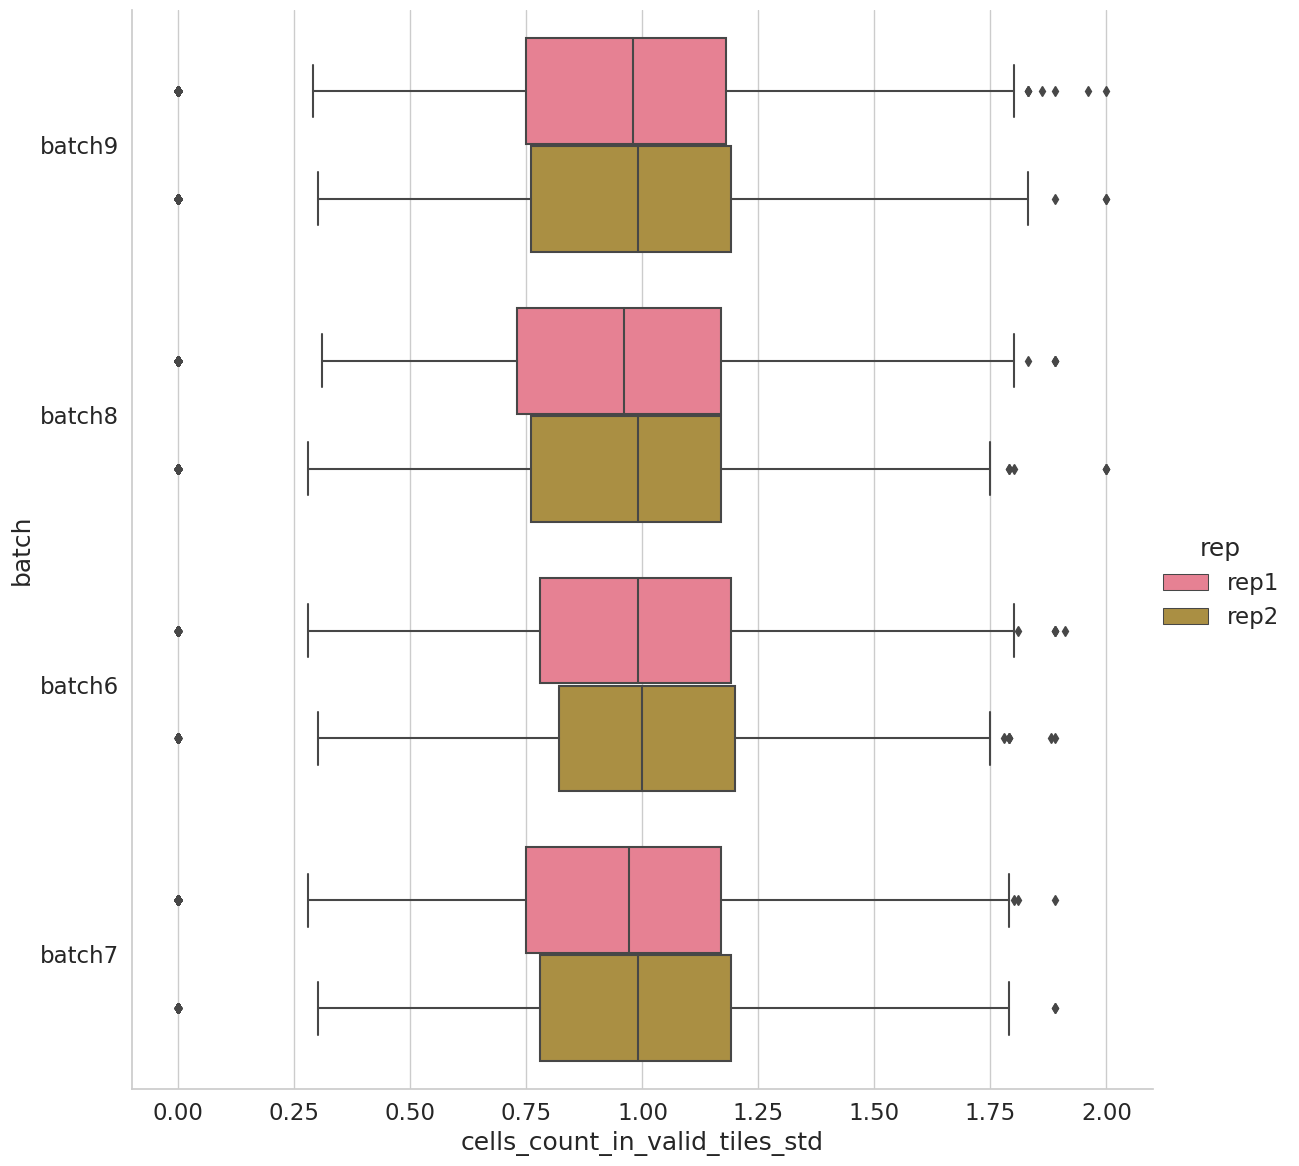

<Figure size 800x800 with 0 Axes>

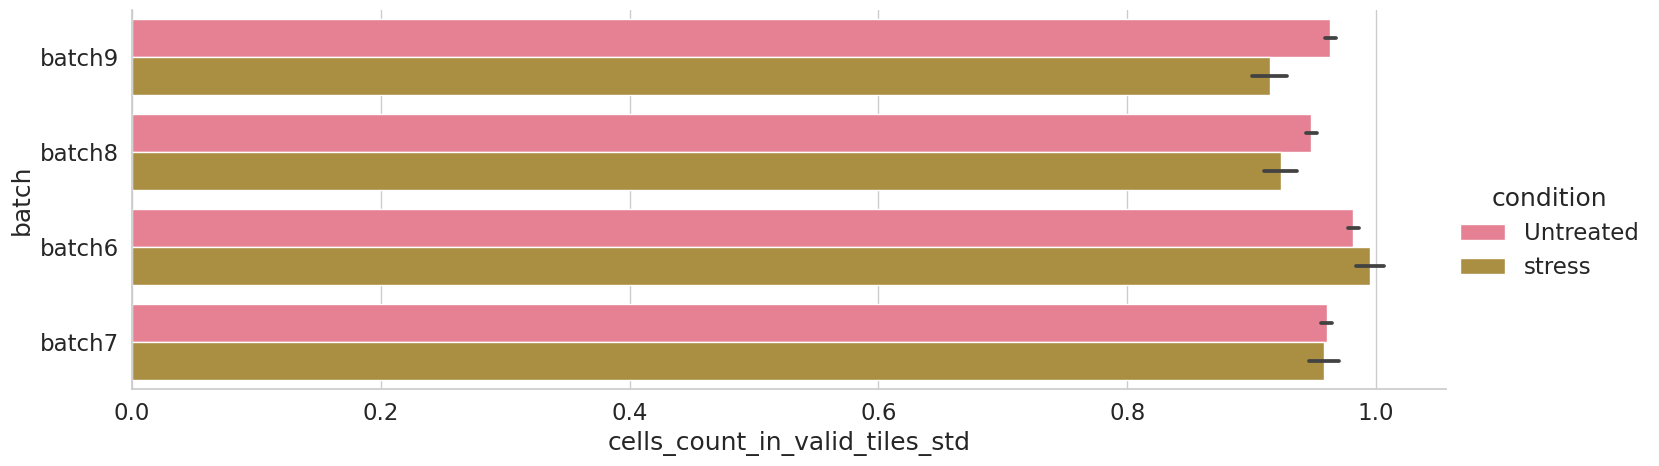

<Figure size 800x800 with 0 Axes>

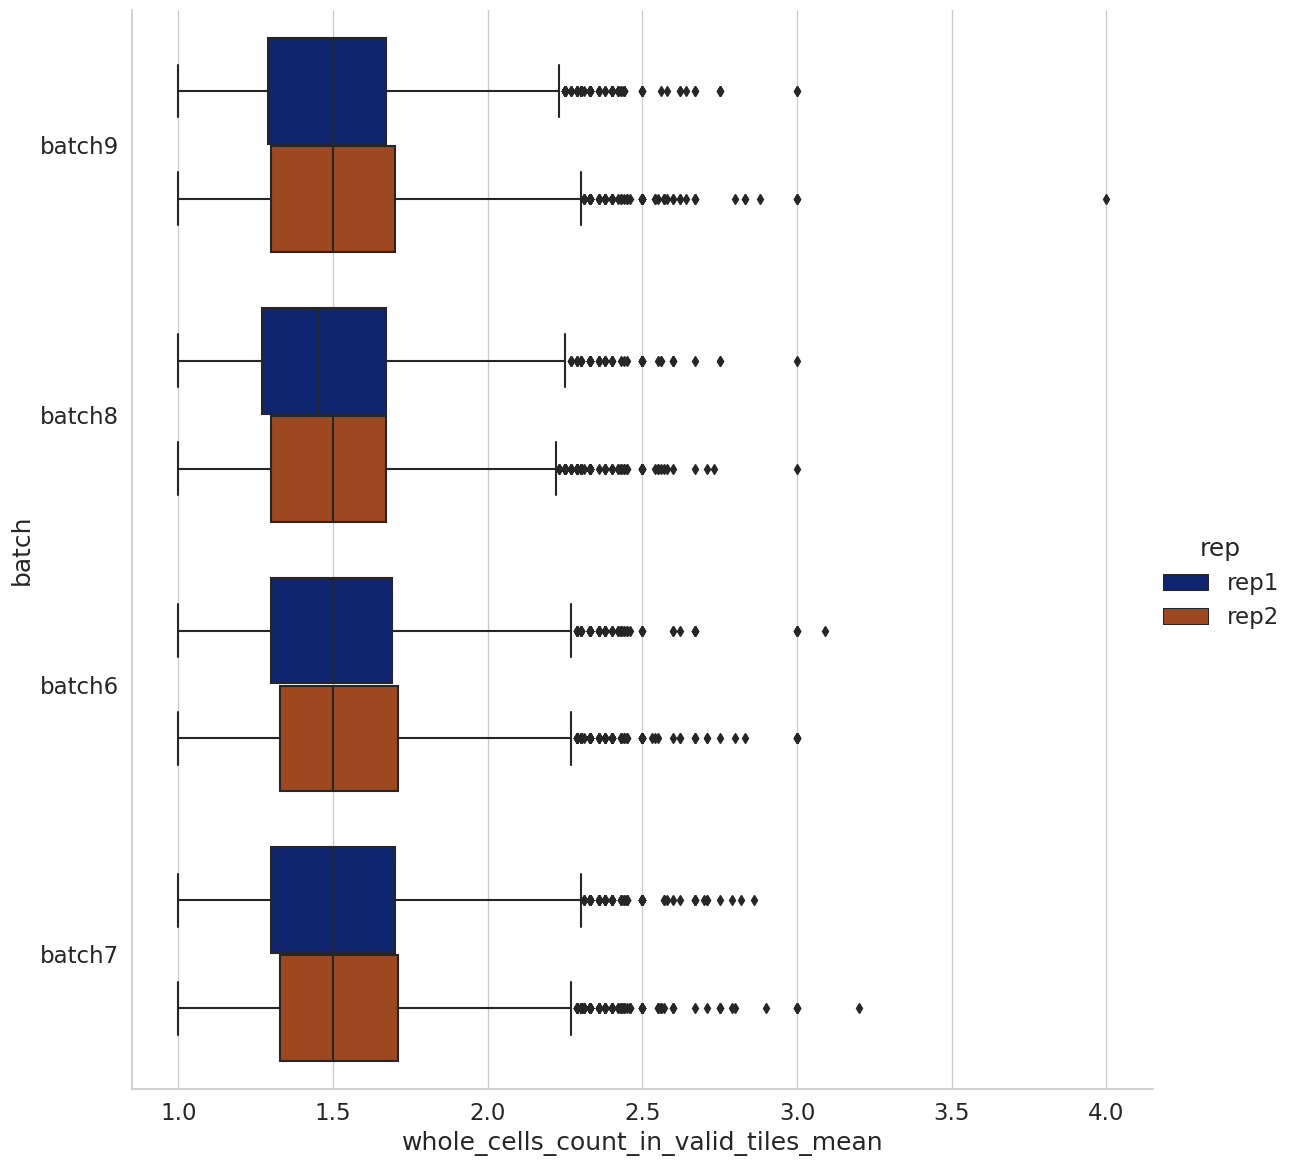

<Figure size 800x800 with 0 Axes>

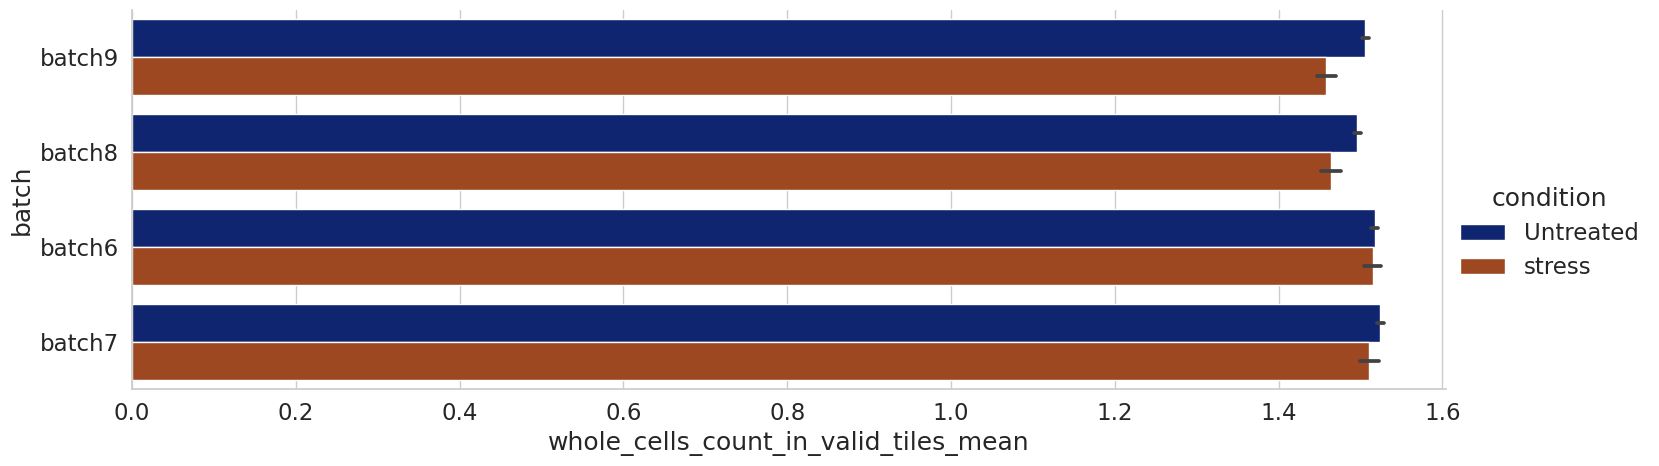

<Figure size 800x800 with 0 Axes>

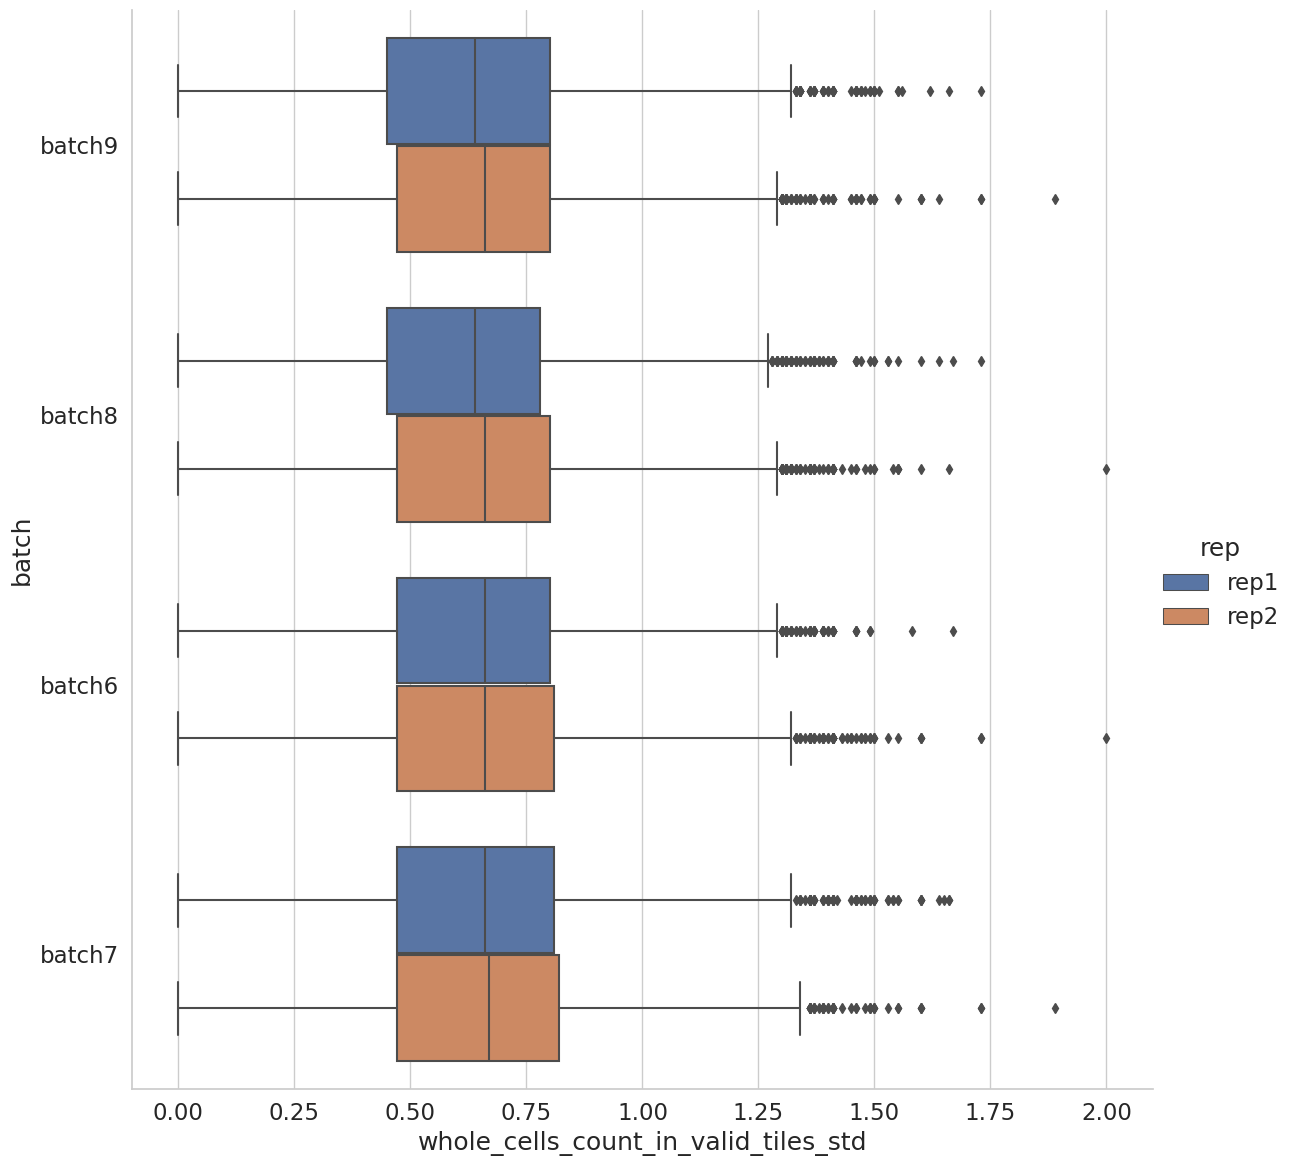

<Figure size 800x800 with 0 Axes>

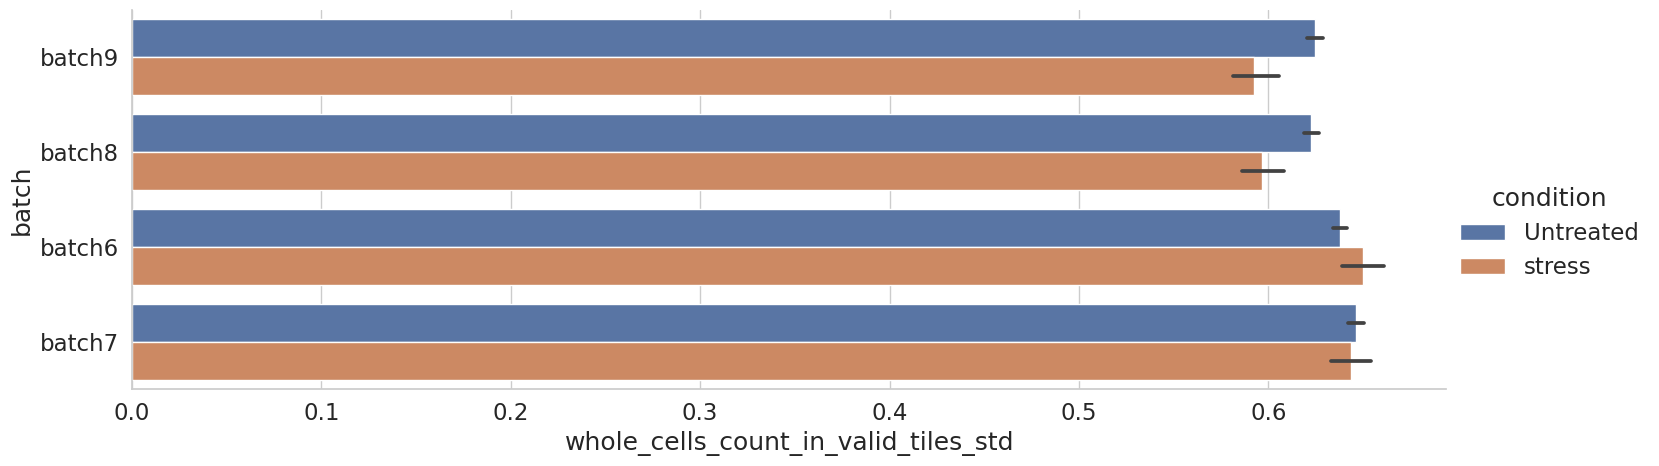

In [13]:
values = ['cells_count_in_valid_tiles_mean', 'cells_count_in_valid_tiles_std',
          'whole_cells_count_in_valid_tiles_mean','whole_cells_count_in_valid_tiles_std']

for value, c_palette in zip(values, ['pastel', 'husl', 'dark', 'deep', 'muted']):

    
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='box', data=df, y='batch', x=value, hue='rep', height=12, palette=sns.color_palette(c_palette))
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='bar', data=df, y='batch', x=value, hue='condition', aspect=3, palette=sns.color_palette(c_palette))



In [14]:
##print(df.groupby(['batch'])['whole_cells_count_in_valid_tiles_mean'].mean())
##print(df.groupby(['cell_line'])['whole_cells_count_in_valid_tiles_mean'].mean())
##print(df.groupby(['batch','cell_line'])['whole_cells_count_in_valid_tiles_mean'].mean())


In [15]:
# save notebook as HTML ( the HTML will be saved in the same folder the original script is)
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
os.system('jupyter nbconvert --to html cell_count_stats_analysis.ipynb')

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook cell_count_stats_analysis.ipynb to html
[NbConvertApp] Writing 5719296 bytes to cell_count_stats_analysis.html


0

In [16]:

print("Done!")

Done!


In [17]:

#mask = df['batch']=='batch3'
#mask2 = df['marker']!='DAPI'
#df[mask & mask2].shape